In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import matplotlib.patches as mpatches
import leidenalg
import igraph as ig
from collections import Counter

# Add the src directory to path for importing our package
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

# Import our DC-SBM implementation
from dcsbm import DCSBM, heldout_split, degrees
from scipy.sparse import csr_matrix

In [116]:
data_path = '/Users/charlesxu/local/data/mcp/flywire/ring_extend/'
results_path = os.path.join(data_path, 'results')
save_data = True
if save_data:
    os.makedirs(results_path, exist_ok=True)

## Preprocessing

Signed matrix shape: (855, 855)


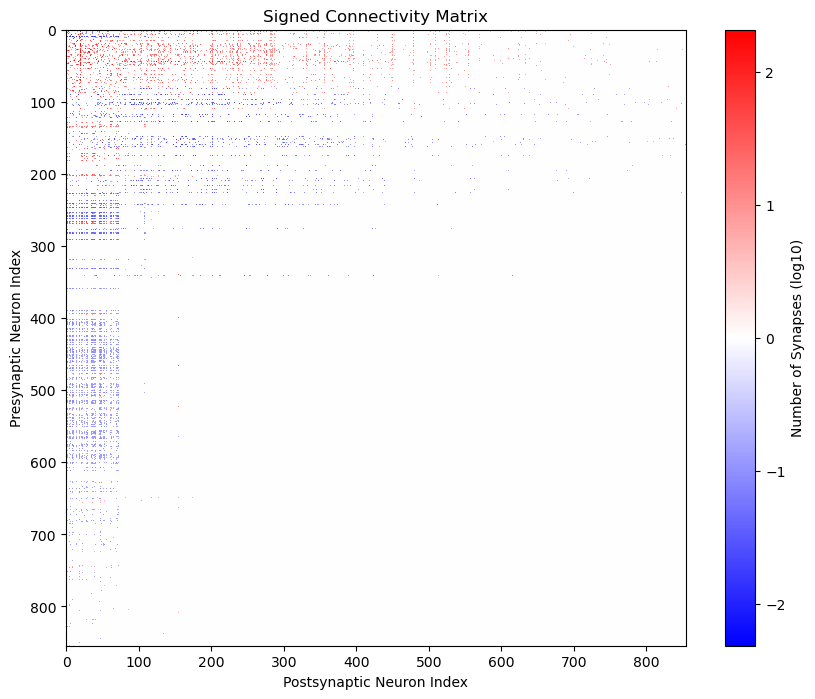

In [117]:
# Read the CSV file
connectivity_matrix_signed_df = pd.read_csv(os.path.join(data_path, 'connectivity_matrix_signed.csv'))

# Convert to square matrix (assuming first column might be row labels)
if connectivity_matrix_signed_df.shape[1] == connectivity_matrix_signed_df.shape[0] + 1:
    # If there's an extra column (likely row labels), drop it
    C_signed = connectivity_matrix_signed_df.iloc[:, 1:].values
else:
    # Otherwise, use all columns
    C_signed = connectivity_matrix_signed_df.values

print(f"Signed matrix shape: {C_signed.shape}")

# Visualize the signed connectivity matrix
plt.figure(figsize=(10, 8))
plt.imshow(np.log10(np.abs(C_signed) + 1) * np.sign(C_signed), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_signed) + 1)), 
           vmax=np.max(np.log10(np.abs(C_signed) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Signed Connectivity Matrix')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')
plt.show()

In [118]:
# Read the ctoi CSV file
ctoi_df = pd.read_csv(os.path.join(data_path, 'ctoi_list.csv'))
ctoi_list = ctoi_df['Cell Type'].tolist()
print(f"Cell type list length: {len(ctoi_list)}")
print(f"First 10 cell types: {ctoi_list[:10]}")

# Read the noi CSV file
noi_df = pd.read_csv(os.path.join(data_path, 'noi_list.csv'))
noi_list = noi_df['Neuron ID'].tolist()
print(f"Neuron ID list length: {len(noi_list)}")
print(f"First 10 neuron IDs: {noi_list[:10]}")

Cell type list length: 855
First 10 cell types: ['EPG', 'EL', 'EPG', 'EL', 'EPG', 'EL', 'EPG', 'EL', 'EPG', 'ExR6']
Neuron ID list length: 855
First 10 neuron IDs: [720575940631125036, 720575940611964882, 720575940626137895, 720575940629459441, 720575940604801993, 720575940629902206, 720575940608722371, 720575940631848791, 720575940628843458, 720575940620027515]


### Group by cell type

In [119]:
## Group by cell type and then for noi and connectivity matrix
# Create a mapping from cell type to indices
cell_type_indices = {}
for i, cell_type in enumerate(ctoi_list):
    if cell_type not in cell_type_indices:
        cell_type_indices[cell_type] = []
    cell_type_indices[cell_type].append(i)

# Get unique cell types in order of first appearance
unique_cell_types = []
seen_types = set()
for cell_type in ctoi_list:
    if cell_type not in seen_types:
        unique_cell_types.append(cell_type)
        seen_types.add(cell_type)

# Sort unique cell types alphabetically
unique_cell_types_sorted = sorted(unique_cell_types)

print(f"Sorted unique cell types: {unique_cell_types_sorted}")
print(f"Number of unique cell types: {len(unique_cell_types_sorted)}")

# Create new ordering with alphabetically sorted cell types
new_order_sorted = []
ctoi_grouped_sorted = []
noi_grouped_sorted = []

for cell_type in unique_cell_types_sorted:
    indices = cell_type_indices[cell_type]
    new_order_sorted.extend(indices)
    # Add cell types for this group
    ctoi_grouped_sorted.extend([cell_type] * len(indices))
    # Add corresponding neuron IDs
    for idx in indices:
        noi_grouped_sorted.append(noi_list[idx])

print(f"Sorted new order length: {len(new_order_sorted)}")
print(f"Sorted grouped ctoi length: {len(ctoi_grouped_sorted)}")
print(f"Sorted grouped noi length: {len(noi_grouped_sorted)}")

# Reorder the connectivity matrix with alphabetically sorted groups
C_signed_grouped_sorted = C_signed[np.ix_(new_order_sorted, new_order_sorted)]

print(f"Sorted grouped matrix shape: {C_signed_grouped_sorted.shape}")

# Update the variables to use the sorted versions
ctoi_grouped = ctoi_grouped_sorted
noi_grouped = noi_grouped_sorted
C_signed_grouped = C_signed_grouped_sorted
new_order = new_order_sorted
unique_cell_types = unique_cell_types_sorted

# Get the number of cells in each cell type
cell_type_counts = {}
for cell_type in unique_cell_types:
    cell_type_counts[cell_type] = len(cell_type_indices[cell_type])

print("Number of cells in each cell type:")
for cell_type in unique_cell_types:
    print(f"{cell_type}: {cell_type_counts[cell_type]}")

print(f"\nTotal number of cell types: {len(unique_cell_types)}")
print(f"Total number of cells: {sum(cell_type_counts.values())}")

Sorted unique cell types: ['CB.FB2I3', 'CB.FB3', 'CB0698', 'Delta7', 'EL', 'EPG', 'EPGt', 'ER1', 'ER2', 'ER3a', 'ER3d', 'ER3m', 'ER3p', 'ER3w', 'ER4d', 'ER4m', 'ER5', 'ER6', 'ExR1', 'ExR2', 'ExR3', 'ExR4', 'ExR5', 'ExR6', 'ExR7', 'ExR8', 'FB1G', 'FB4A', 'FB4Y', 'FB5V', 'FB5Z', 'FC2C', 'FS2', 'FS4A', 'GLNO', 'IbSpsP', 'LAL117', 'LAL121', 'LAL123', 'LAL184', 'LAL190', 'LHPV6q1', 'LPsP', 'M_lPNm12', 'OCG08', 'P1-9', 'P6-8P9', 'PEG', 'PEN_a(PEN1)', 'PEN_b(PEN2)', 'PFGs', 'PFL1', 'PFL2', 'PFL3', 'PFNa', 'PFNd', 'PFNm', 'PFNv', 'PFR', 'SIFa', 'WED160', 'cM11', 'hDeltaA', 'hDeltaB', 'hDeltaG', 'hDeltaI', 'hb-1934975261', 'hb-5813069570']
Number of unique cell types: 68
Sorted new order length: 855
Sorted grouped ctoi length: 855
Sorted grouped noi length: 855
Sorted grouped matrix shape: (855, 855)
Number of cells in each cell type:
CB.FB2I3: 2
CB.FB3: 3
CB0698: 1
Delta7: 40
EL: 17
EPG: 47
EPGt: 4
ER1: 29
ER2: 41
ER3a: 1
ER3d: 42
ER3m: 15
ER3p: 17
ER3w: 25
ER4d: 26
ER4m: 11
ER5: 17
ER6: 4
ExR

### Remove unconnected nodes

In [120]:
C_unsigned_grouped = np.abs(C_signed_grouped)

# Detect unconnected neurons: both in-degree and out-degree are zero
out_degree = np.sum(C_unsigned_grouped, axis=1)
in_degree = np.sum(C_unsigned_grouped, axis=0)

# Find neurons with zero degree (both in and out)
zero_degree_mask = (out_degree == 0) & (in_degree == 0)
unconnected_indices = np.where(zero_degree_mask)[0]
connected_indices = np.where(~zero_degree_mask)[0]

print(f"Total neurons: {len(C_unsigned_grouped)}")
print(f"Unconnected neurons (zero in-degree and out-degree): {len(unconnected_indices)}")
print(f"Connected neurons: {len(connected_indices)}")

if len(unconnected_indices) > 0:
    print(f"\nUnconnected neuron indices: {unconnected_indices[:20]}...")  # Show first 20
    
    # Display cell types of unconnected neurons
    unconnected_cell_types = [ctoi_grouped[i] for i in unconnected_indices]
    cell_type_distribution = Counter(unconnected_cell_types)
    print(f"\nCell type distribution of unconnected neurons:")
    for cell_type, count in sorted(cell_type_distribution.items()):
        print(f"  {cell_type}: {count}")
    
    # Remove unconnected neurons from all relevant data structures
    C_signed_grouped_connected = C_signed_grouped[np.ix_(connected_indices, connected_indices)]
    C_unsigned_grouped_connected = C_unsigned_grouped[np.ix_(connected_indices, connected_indices)]
    ctoi_grouped_connected = [ctoi_grouped[i] for i in connected_indices]
    noi_grouped_connected = [noi_grouped[i] for i in connected_indices]
    new_order_connected = [new_order[i] for i in connected_indices]
    
    print(f"\nConnected matrix shape: {C_unsigned_grouped_connected.shape}")
    print(f"Connected ctoi length: {len(ctoi_grouped_connected)}")
    print(f"Connected noi length: {len(noi_grouped_connected)}")
    
    # Update variables to use connected versions
    C_signed_grouped = C_signed_grouped_connected
    C_unsigned_grouped = C_unsigned_grouped_connected
    ctoi_grouped = ctoi_grouped_connected
    noi_grouped = noi_grouped_connected
    new_order = new_order_connected
    unique_cell_types = np.unique(ctoi_grouped).tolist()
    
    # Recalculate cell type counts
    cell_type_counts = {}
    for cell_type in ctoi_grouped:
        cell_type_counts[cell_type] = cell_type_counts.get(cell_type, 0) + 1
    
    print(f"\nUpdated cell type counts (connected neurons only):")
    print(f"Number of unique cell types: {len(unique_cell_types)}")
else:
    print("\nAll neurons are connected.")

Total neurons: 855
Unconnected neurons (zero in-degree and out-degree): 0
Connected neurons: 855

All neurons are connected.


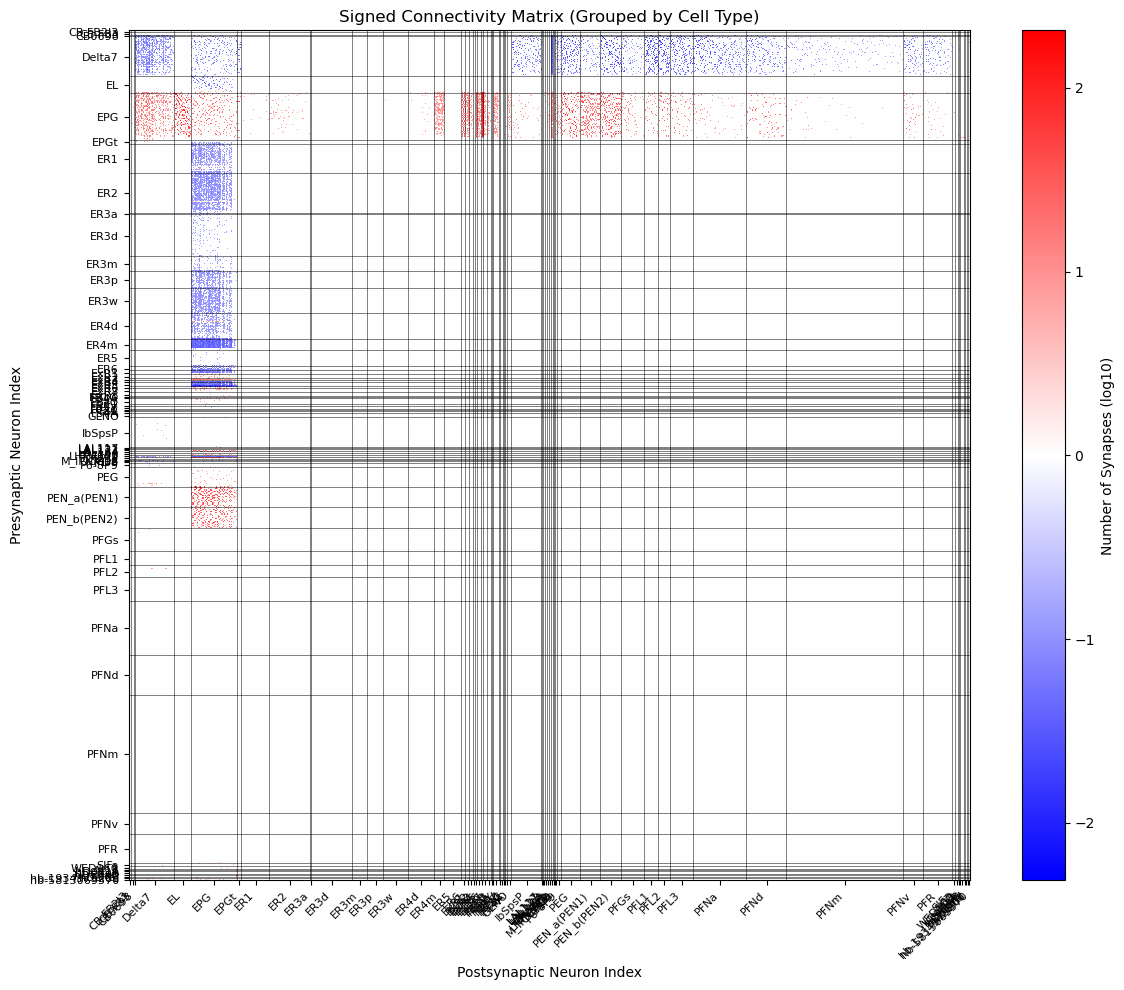

In [121]:
# Visualize the grouped connectivity matrix with cell type labels
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_signed_grouped) + 1) * np.sign(C_signed_grouped), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_signed_grouped) + 1)), 
           vmax=np.max(np.log10(np.abs(C_signed_grouped) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Signed Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

### Weight-only (unsigned) matrix

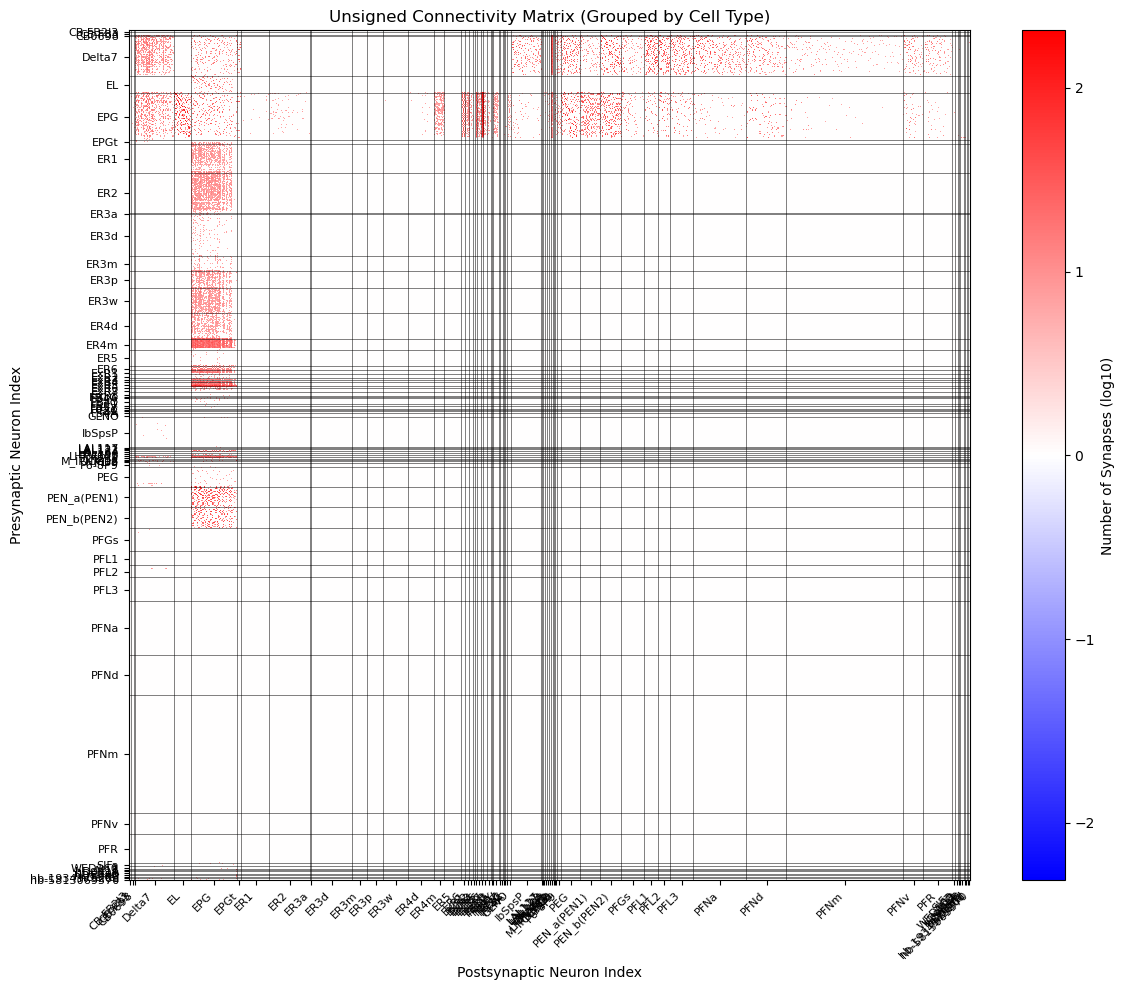

In [122]:
# Visualize the unsigned grouped connectivity matrix
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_unsigned_grouped) + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_unsigned_grouped) + 1)), 
           vmax=np.max(np.log10(np.abs(C_unsigned_grouped) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Unsigned Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Workspace checkpoint
variables_to_keep = ['ctoi_grouped', 'noi_grouped', 'C_signed_grouped', 'C_unsigned_grouped', 'new_order', 'unique_cell_types', 'cell_type_counts']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 855
	noi_grouped: list, length: 855
	C_signed_grouped: ndarray, shape: (855, 855)
	C_unsigned_grouped: ndarray, shape: (855, 855)
	new_order: list, length: 855
	unique_cell_types: list, length: 68
	cell_type_counts: dict, length: 68


### Select cell types

In [125]:
select_cell_type = ['Delta7', 'EPG']
select_indices = [i for i, ct in enumerate(ctoi_grouped) if ct in select_cell_type]
ctoi_grouped = [ctoi_grouped[i] for i in select_indices]
noi_grouped = [noi_grouped[i] for i in select_indices]
C_signed_grouped = C_signed_grouped[np.ix_(select_indices, select_indices)]
C_unsigned_grouped = C_unsigned_grouped[np.ix_(select_indices, select_indices)]
new_order = [new_order[i] for i in select_indices]
unique_cell_types = select_cell_type
cell_type_counts = {ct: ctoi_grouped.count(ct) for ct in unique_cell_types}

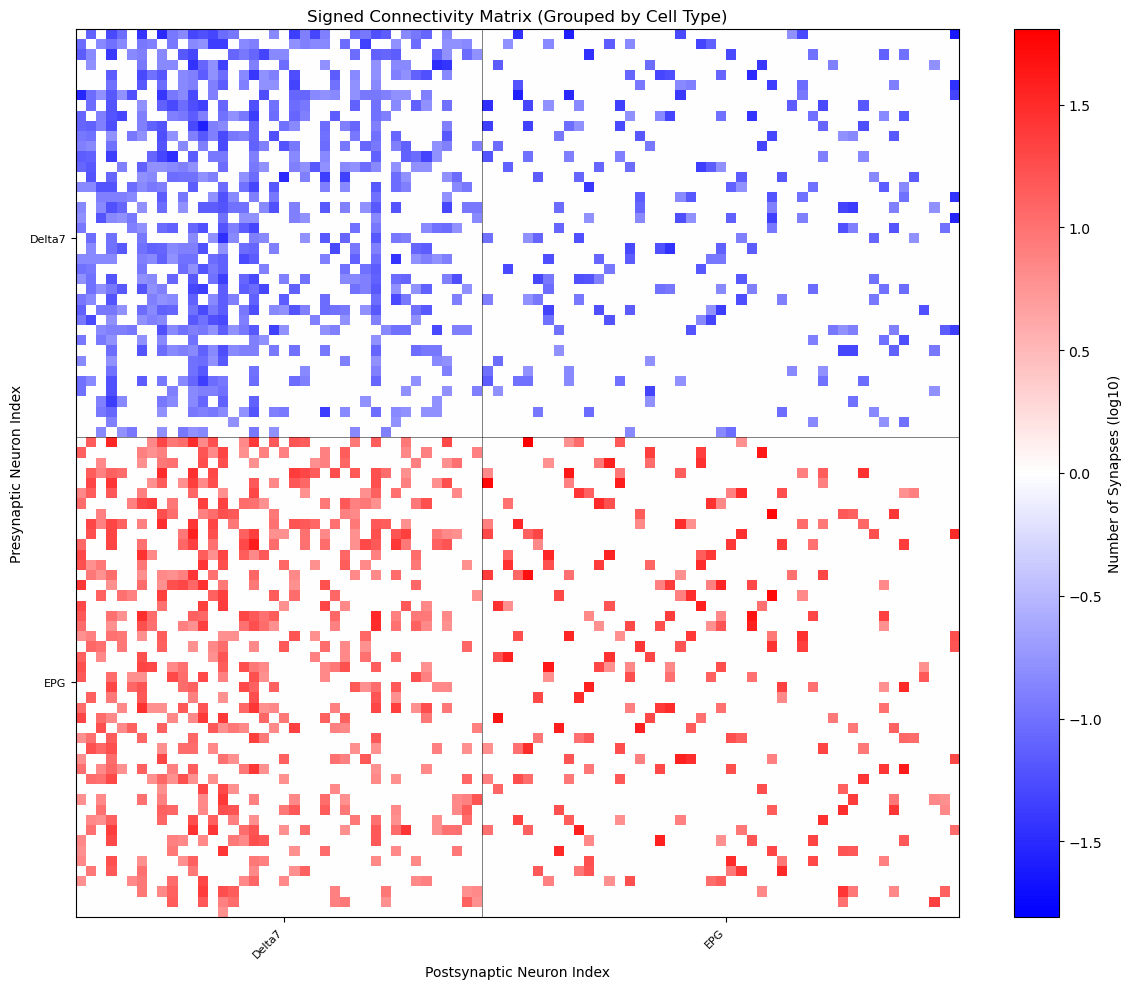

In [126]:
# Visualize the grouped connectivity matrix with cell type labels
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_signed_grouped) + 1) * np.sign(C_signed_grouped), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_signed_grouped) + 1)), 
           vmax=np.max(np.log10(np.abs(C_signed_grouped) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Signed Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

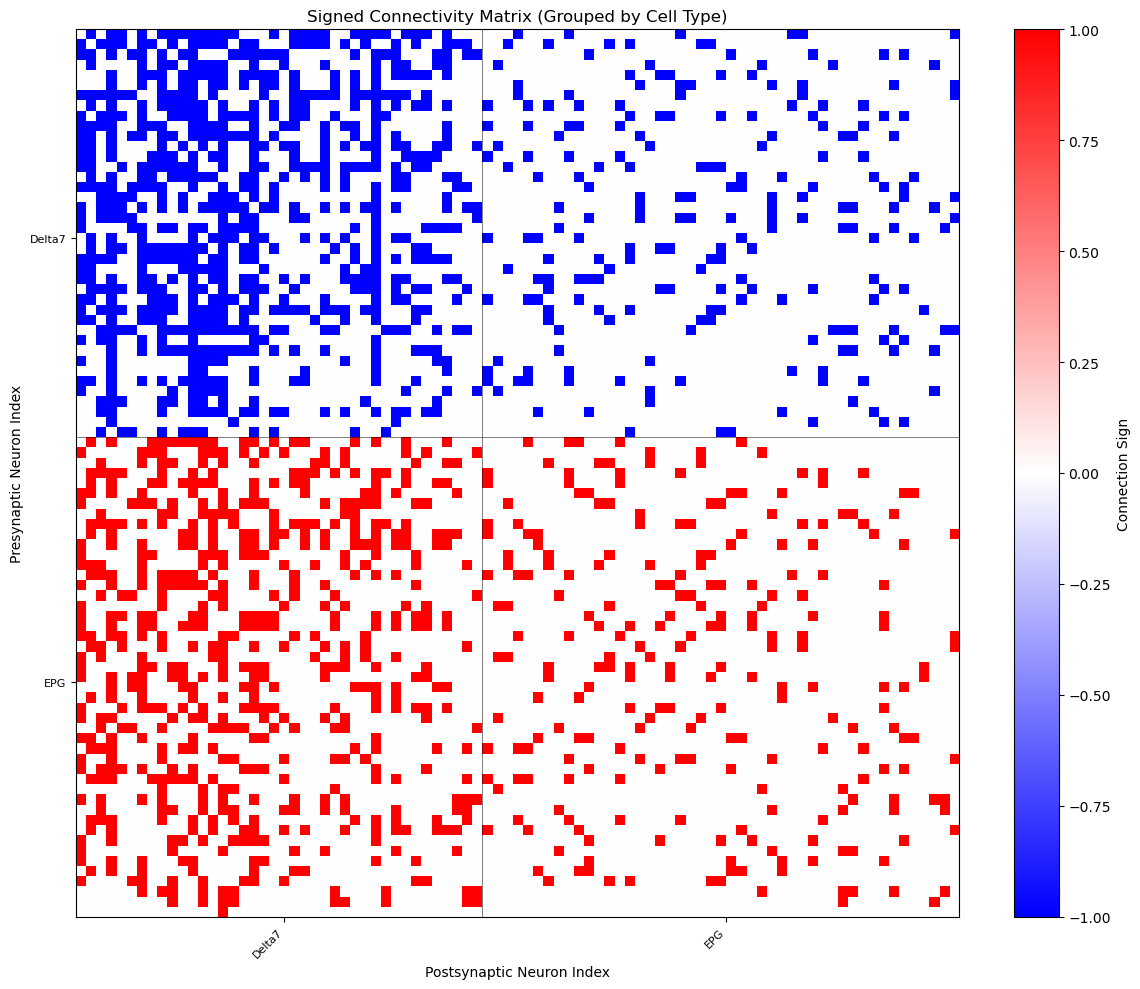

In [127]:
# Visualize the grouped connectivity matrix with cell type labels
plt.figure(figsize=(12, 10))
plt.imshow(np.sign(C_signed_grouped), 
           cmap='bwr', aspect='auto', 
           vmin=-1, 
           vmax=1,
           interpolation='none')
plt.colorbar(label='Connection Sign')
plt.title('Signed Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

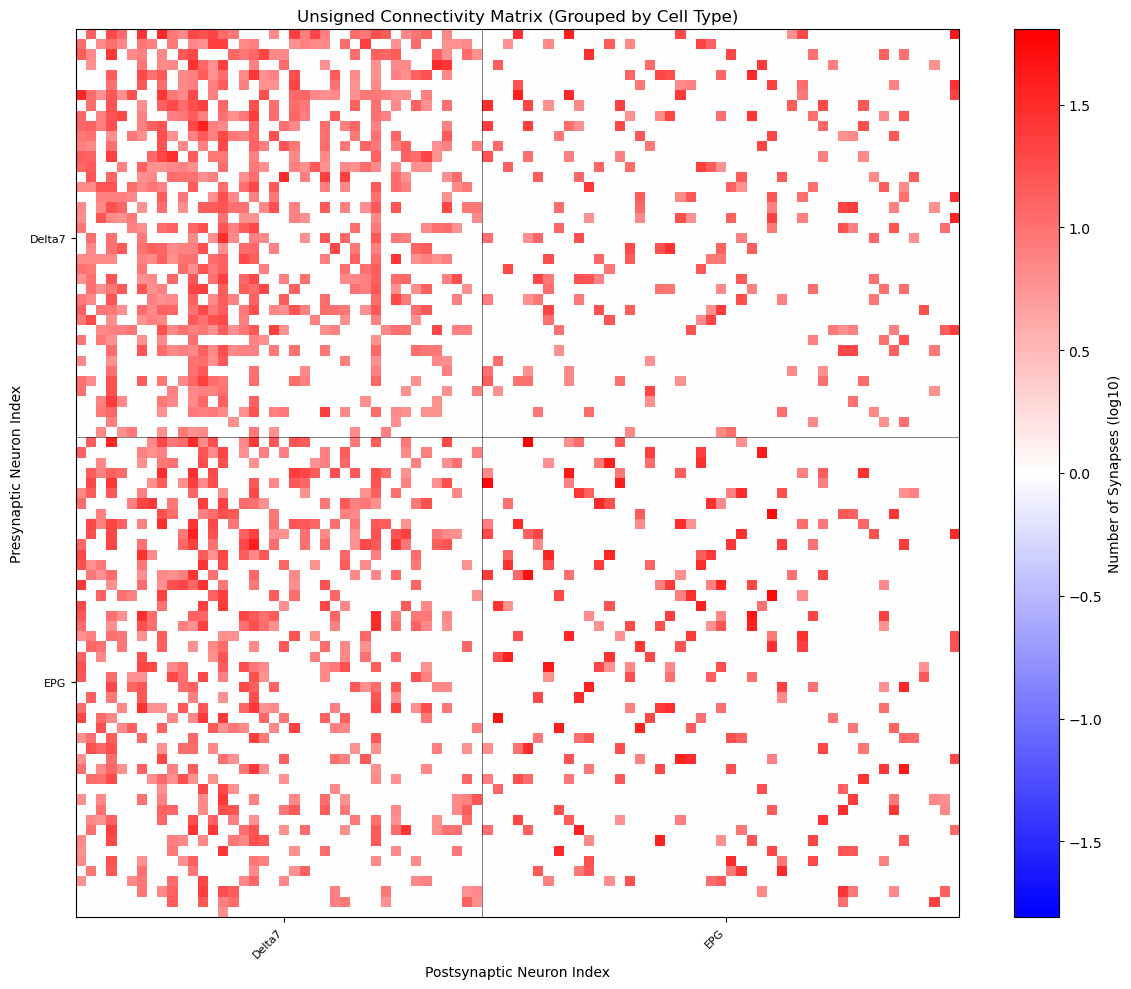

In [128]:
# Visualize the unsigned grouped connectivity matrix
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_unsigned_grouped) + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_unsigned_grouped) + 1)), 
           vmax=np.max(np.log10(np.abs(C_unsigned_grouped) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Unsigned Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [129]:
variables_to_keep = ['ctoi_grouped', 'noi_grouped', 'C_signed_grouped', 'C_unsigned_grouped', 'new_order', 'unique_cell_types', 'cell_type_counts']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 87
	noi_grouped: list, length: 87
	C_signed_grouped: ndarray, shape: (87, 87)
	C_unsigned_grouped: ndarray, shape: (87, 87)
	new_order: list, length: 87
	unique_cell_types: list, length: 2
	cell_type_counts: dict, length: 2


### Normalization

#### Uniform scaling

#### Information-based normalization

## System reduction

In [130]:
A = C_unsigned_grouped

### Graph Laplacians

#### Directed, combinatorial Laplacians

In [132]:
# Compute out-degree and in-degree for A
# Out-degree: sum of outgoing connections (row sums)
D_out = np.sum(A, axis=1)

# In-degree: sum of incoming connections (column sums)
D_in = np.sum(A, axis=0)

print(f"Out-degree D_out shape: {D_out.shape}")
print(f"In-degree D_in shape: {D_in.shape}")
print(f"Out-degree range: {D_out.min():.2f} - {D_out.max():.2f}")
print(f"In-degree range: {D_in.min():.2f} - {D_in.max():.2f}")

# Create diagonal degree matrices
D_out = np.diag(D_out)
D_in = np.diag(D_in)

# Compute out-degree Laplacian: L_out = D_out - A
L_out = D_out - A

# Compute in-degree Laplacian: L_in = D_in - A^T
L_in = D_in - A.T

print(f"\nOut-degree Laplacian L_out shape: {L_out.shape}")
print(f"In-degree Laplacian L_in shape: {L_in.shape}")

# Verify Laplacian properties
# Row sums of L_out should be zero
row_sums_L_out = np.sum(L_out, axis=1)
print(f"\nL_out row sums (should be ~0): max abs = {np.abs(row_sums_L_out).max():.2e}")

# Column sums of L_in should be zero
col_sums_L_in = np.sum(L_in, axis=0)
print(f"L_in column sums (should be ~0): max abs = {np.abs(col_sums_L_in).max():.2e}")

# Show some statistics
print(f"\nDegree statistics:")
print(f"Mean out-degree: {D_out.mean():.2f}")
print(f"Mean in-degree: {D_in.mean():.2f}")
print(f"Std out-degree: {D_out.std():.2f}")
print(f"Std in-degree: {D_in.std():.2f}")

Out-degree D_out shape: (87,)
In-degree D_in shape: (87,)
Out-degree range: 5.00 - 471.00
In-degree range: 23.00 - 812.00

Out-degree Laplacian L_out shape: (87, 87)
In-degree Laplacian L_in shape: (87, 87)

L_out row sums (should be ~0): max abs = 0.00e+00
L_in column sums (should be ~0): max abs = 5.42e+02

Degree statistics:
Mean out-degree: 2.63
Mean in-degree: 2.63
Std out-degree: 25.92
Std in-degree: 30.63


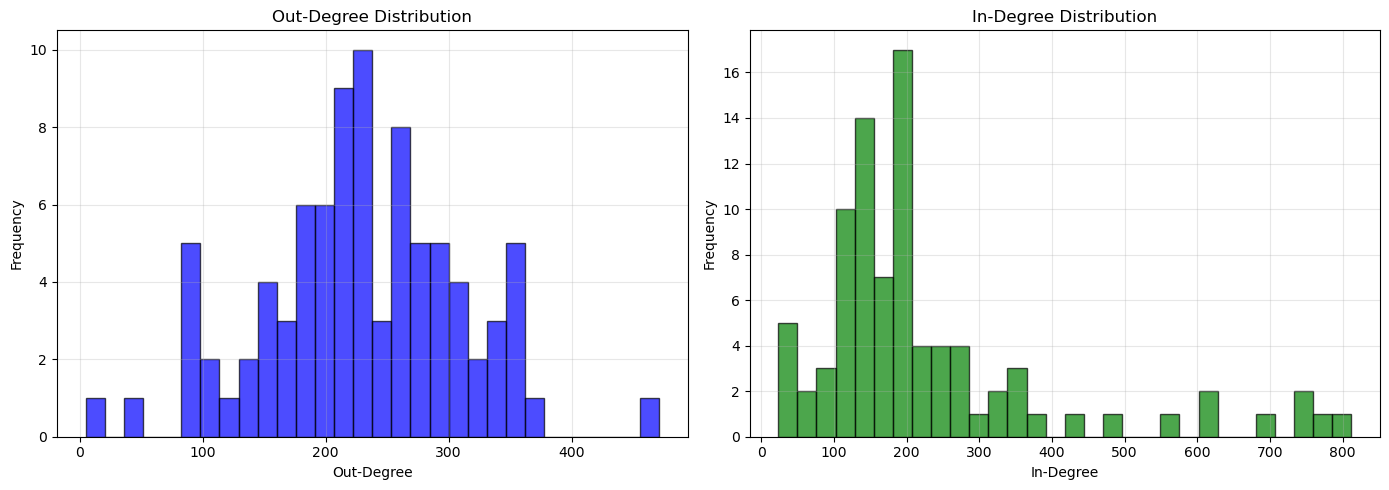

Out-Degree Statistics:
  Mean: 229.11
  Std: 81.04
  Min: 5.00
  Max: 471.00

In-Degree Statistics:
  Mean: 229.11
  Std: 172.46
  Min: 23.00
  Max: 812.00


In [133]:
# Calculate out-degree and in-degree
out_degree = np.sum(A, axis=1)
in_degree = np.sum(A, axis=0)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot out-degree distribution
axes[0].hist(out_degree, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Out-Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Out-Degree Distribution')
axes[0].grid(True, alpha=0.3)

# Plot in-degree distribution
axes[1].hist(in_degree, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Frequency')
axes[1].set_title('In-Degree Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Out-Degree Statistics:")
print(f"  Mean: {out_degree.mean():.2f}")
print(f"  Std: {out_degree.std():.2f}")
print(f"  Min: {out_degree.min():.2f}")
print(f"  Max: {out_degree.max():.2f}")

print("\nIn-Degree Statistics:")
print(f"  Mean: {in_degree.mean():.2f}")
print(f"  Std: {in_degree.std():.2f}")
print(f"  Min: {in_degree.min():.2f}")
print(f"  Max: {in_degree.max():.2f}")

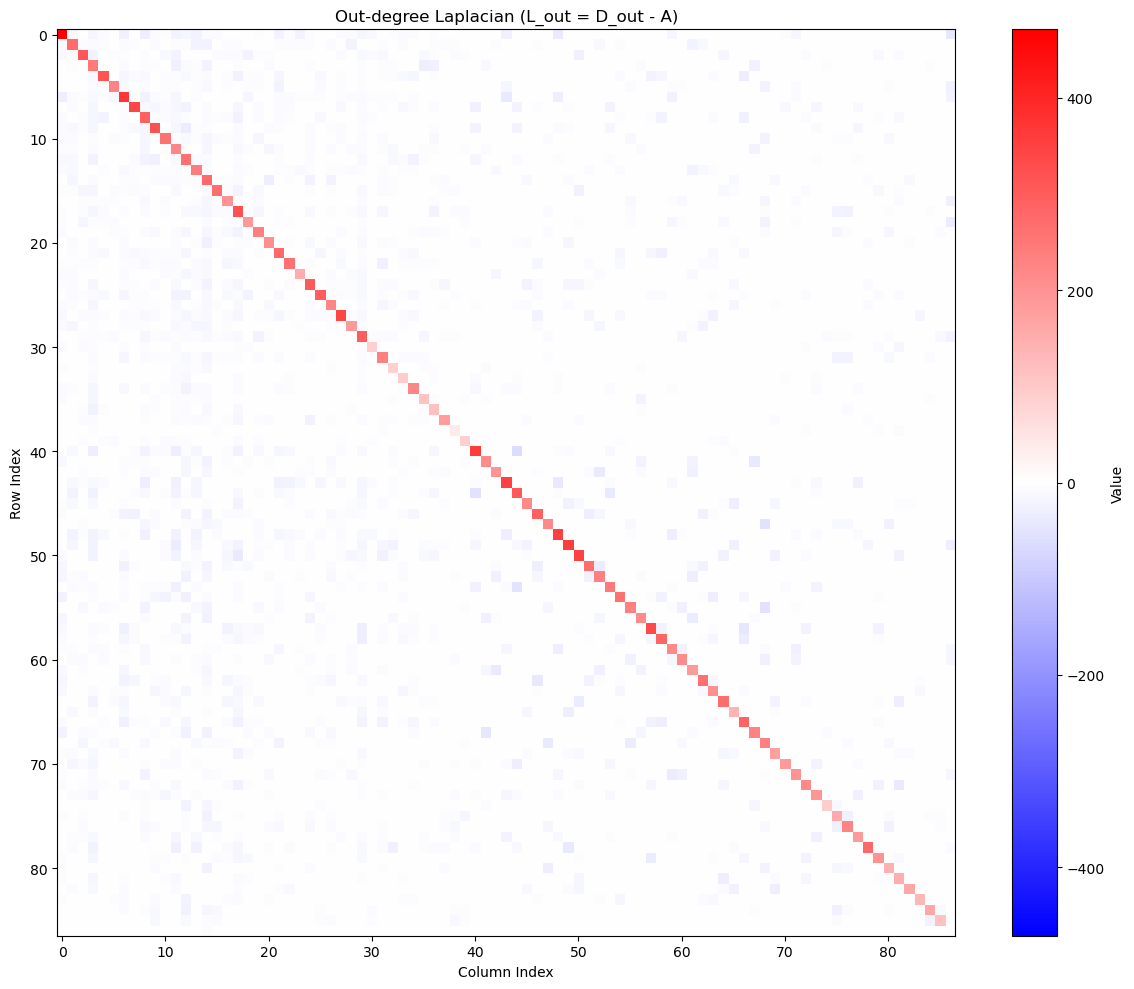

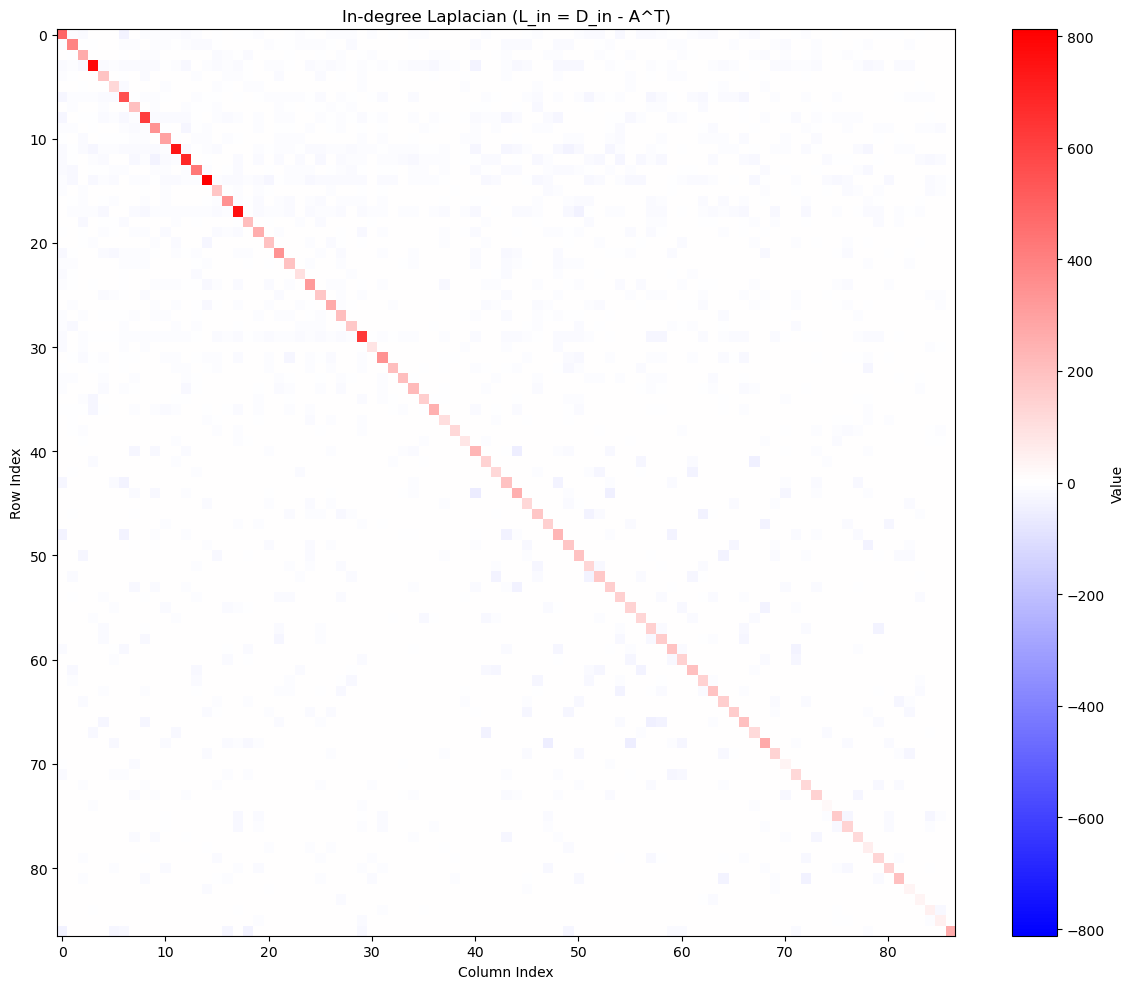

Out-degree Laplacian (L_out) statistics:
  Min: -63.00
  Max: 471.00
  Mean: 0.00
  Std: 26.85

In-degree Laplacian (L_in) statistics:
  Min: -63.00
  Max: 812.00
  Mean: 0.00
  Std: 31.43


In [134]:
# Visualize the out-degree and in-degree Laplacians
# Plot L_out
plt.figure(figsize=(12, 10))
plt.imshow(L_out, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(L_out)), 
           vmax=np.max(np.abs(L_out)), 
           interpolation='none')
plt.colorbar(label='Value')
plt.title('Out-degree Laplacian (L_out = D_out - A)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

# Plot L_in
plt.figure(figsize=(12, 10))
plt.imshow(L_in, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(L_in)), 
           vmax=np.max(np.abs(L_in)), 
           interpolation='none')
plt.colorbar(label='Value')
plt.title('In-degree Laplacian (L_in = D_in - A^T)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

# Show some statistics about the Laplacians
print("Out-degree Laplacian (L_out) statistics:")
print(f"  Min: {L_out.min():.2f}")
print(f"  Max: {L_out.max():.2f}")
print(f"  Mean: {L_out.mean():.2f}")
print(f"  Std: {L_out.std():.2f}")

print("\nIn-degree Laplacian (L_in) statistics:")
print(f"  Min: {L_in.min():.2f}")
print(f"  Max: {L_in.max():.2f}")
print(f"  Mean: {L_in.mean():.2f}")
print(f"  Std: {L_in.std():.2f}")

#### Random walk Laplacian

In [135]:
# Compute random walk Laplacian L_rw = I - D_out^(-1) * A
# First, compute D_out^(-1)
try:
    D_out_inv = np.linalg.inv(D_out)
    
    # Compute the random walk Laplacian
    I = np.eye(len(A))
    L_rw = I - D_out_inv @ A

    print(f"Random walk Laplacian L_rw shape: {L_rw.shape}")

    # Verify properties of random walk Laplacian
    # Row sums should be zero (since each row of D_out^(-1) * A sums to 1)
    row_sums_L_rw = np.sum(L_rw, axis=1)
    print(f"L_rw row sums (should be ~0): max abs = {np.abs(row_sums_L_rw).max():.2e}")

    # Check for any numerical issues (zeros on diagonal of D_out would cause problems)
    print(f"\nMin diagonal value of D_out: {np.diag(D_out).min():.2f}")
    print(f"Number of zero-degree nodes: {np.count_nonzero(np.diag(D_out) == 0)}")

    # Show some statistics
    print(f"\nRandom walk Laplacian statistics:")
    print(f"L_rw min: {L_rw.min():.4f}")
    print(f"L_rw max: {L_rw.max():.4f}")
    print(f"L_rw mean: {L_rw.mean():.4f}")
except Exception as e:
    print("Error computing random walk Laplacian:", e)

Random walk Laplacian L_rw shape: (87, 87)
L_rw row sums (should be ~0): max abs = 2.22e-16

Min diagonal value of D_out: 5.00
Number of zero-degree nodes: 0

Random walk Laplacian statistics:
L_rw min: -1.0000
L_rw max: 1.0000
L_rw mean: -0.0000


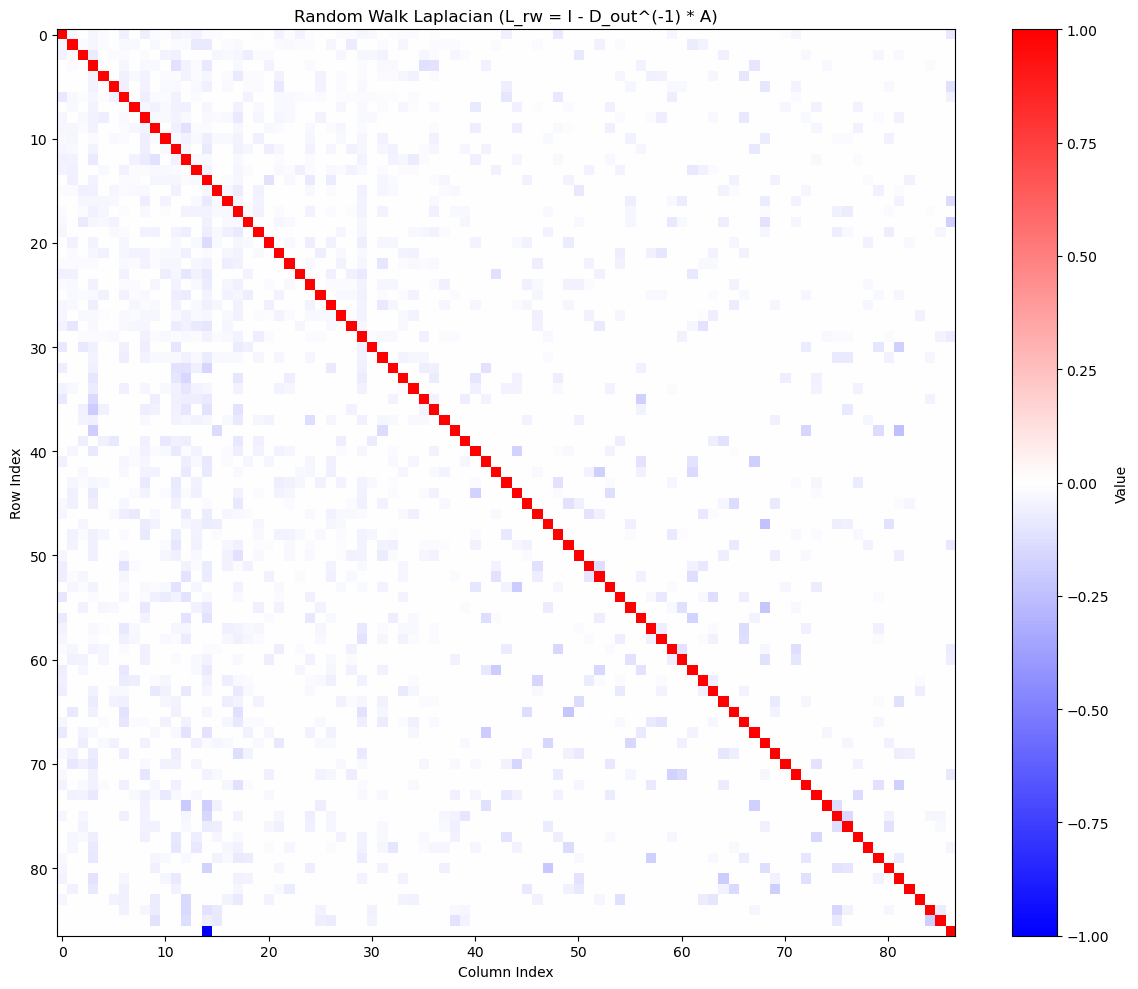

In [ ]:
# Visualize the random walk Laplacian
# Plot L_rw
plt.figure(figsize=(12, 10))
plt.imshow(L_rw, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(L_rw)), 
           vmax=np.max(np.abs(L_rw)), 
           interpolation='none')
plt.colorbar(label='Value')
plt.title('Random Walk Laplacian (L_rw = I - D_out^(-1) * A)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

#### Normalized Laplacian

##### Symmetrize then normalize

In [ ]:
# Compute the symmetric Laplacian L_sym = I - D^(-1/2) * A_sym * D^(-1/2)
A_sym = (A + A.T) / 2
D_sym = np.diag(np.sum(A_sym, axis=1))
try:
    D_sym_inv_sqrt = np.linalg.inv(np.sqrt(D_sym))
    
    # Compute the symmetric Laplacian
    I = np.eye(len(A_sym))
    L_sym_norm = I - D_sym_inv_sqrt @ A_sym @ D_sym_inv_sqrt

    print(f"Symmetric Laplacian L_sym_norm shape: {L_sym_norm.shape}")

    # Verify properties of symmetric Laplacian
    # Row sums should be zero
    row_sums_L_sym_norm = np.sum(L_sym_norm, axis=1)
    print(f"L_sym_norm row sums (should be ~0): max abs = {np.abs(row_sums_L_sym_norm).max():.2e}")

    # Check for any numerical issues (zeros on diagonal of D_sym would cause problems)
    print(f"\nMin diagonal value of D_sym: {np.diag(D_sym).min():.2f}")
    print(f"Number of zero-degree nodes: {np.count_nonzero(np.diag(D_sym) == 0)}")

    # Show some statistics
    print(f"\nSymmetric Laplacian statistics:")
    print(f"L_sym_norm min: {L_sym_norm.min():.4f}")
    print(f"L_sym_norm max: {L_sym_norm.max():.4f}")
    print(f"L_sym_norm mean: {L_sym_norm.mean():.4f}")
except Exception as e:
    print("Error computing symmetric Laplacian:", e)

Symmetric Laplacian L_sym_norm shape: (87, 87)
L_sym_norm row sums (should be ~0): max abs = 5.99e-01

Min diagonal value of D_sym: 58.00
Number of zero-degree nodes: 0

Symmetric Laplacian statistics:
L_sym_norm min: -0.2468
L_sym_norm max: 1.0000
L_sym_norm mean: 0.0006


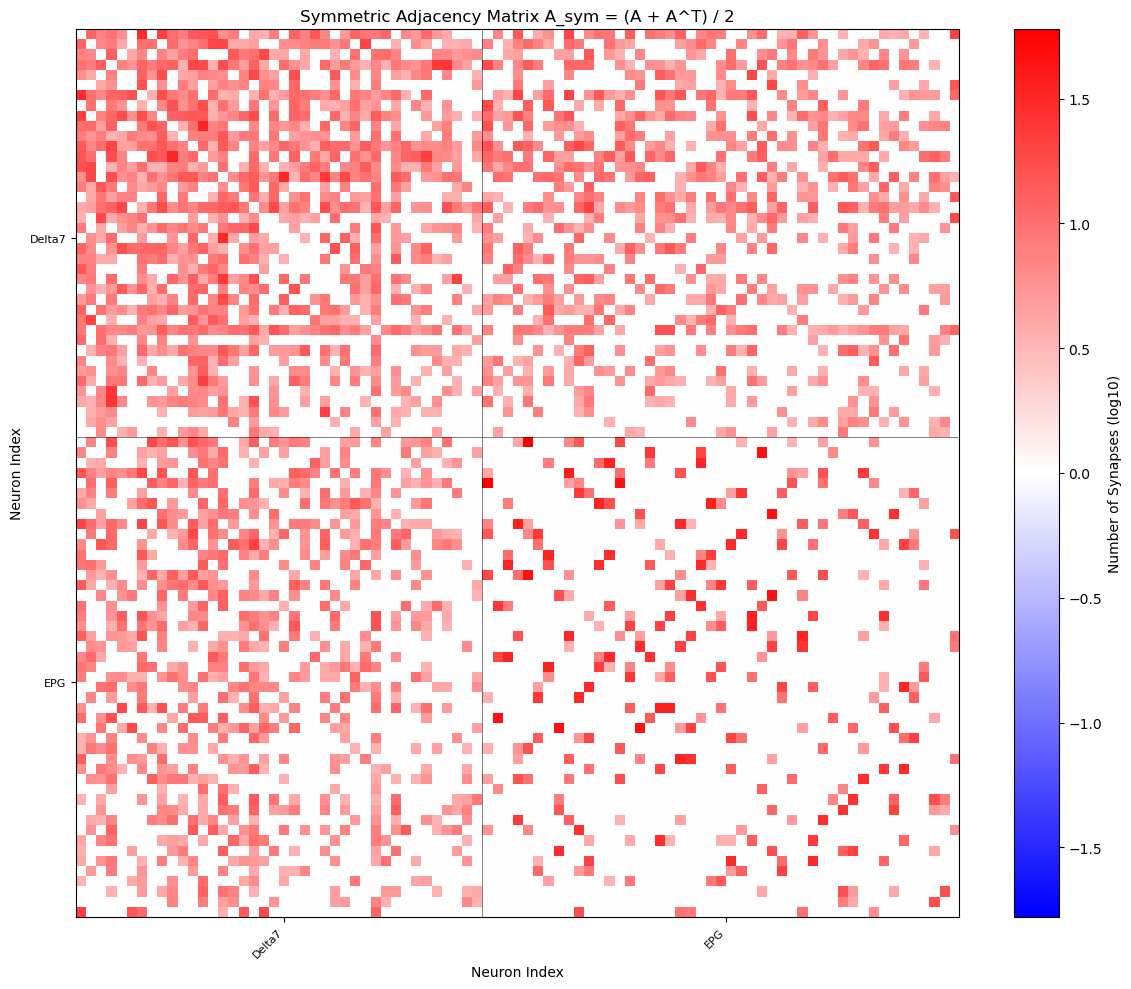

A_sym shape: (87, 87)
A_sym min: 0.00
A_sym max: 59.00
A_sym mean: 2.63
Number of non-zero entries: 2734

Symmetry error (should be ~0): 0.00e+00


In [155]:
# Visualize the symmetric adjacency matrix A_sym
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(A_sym + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(np.log10(A_sym + 1))), 
           vmax=np.max(np.abs(np.log10(A_sym + 1))),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Symmetric Adjacency Matrix A_sym = (A + A^T) / 2')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')

# Add cell type group boundaries
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = cell_type_counts[cell_type]
    group_boundaries.append(current_pos + group_size)
    
    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)
    
    current_pos += group_size

# Set x and y ticks with cell type labels
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
plt.yticks(tick_positions, tick_labels, fontsize=8)

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Show statistics
print(f"A_sym shape: {A_sym.shape}")
print(f"A_sym min: {A_sym.min():.2f}")
print(f"A_sym max: {A_sym.max():.2f}")
print(f"A_sym mean: {A_sym.mean():.2f}")
print(f"Number of non-zero entries: {np.count_nonzero(A_sym)}")

# Verify symmetry
symmetry_error = np.max(np.abs(A_sym - A_sym.T))
print(f"\nSymmetry error (should be ~0): {symmetry_error:.2e}")

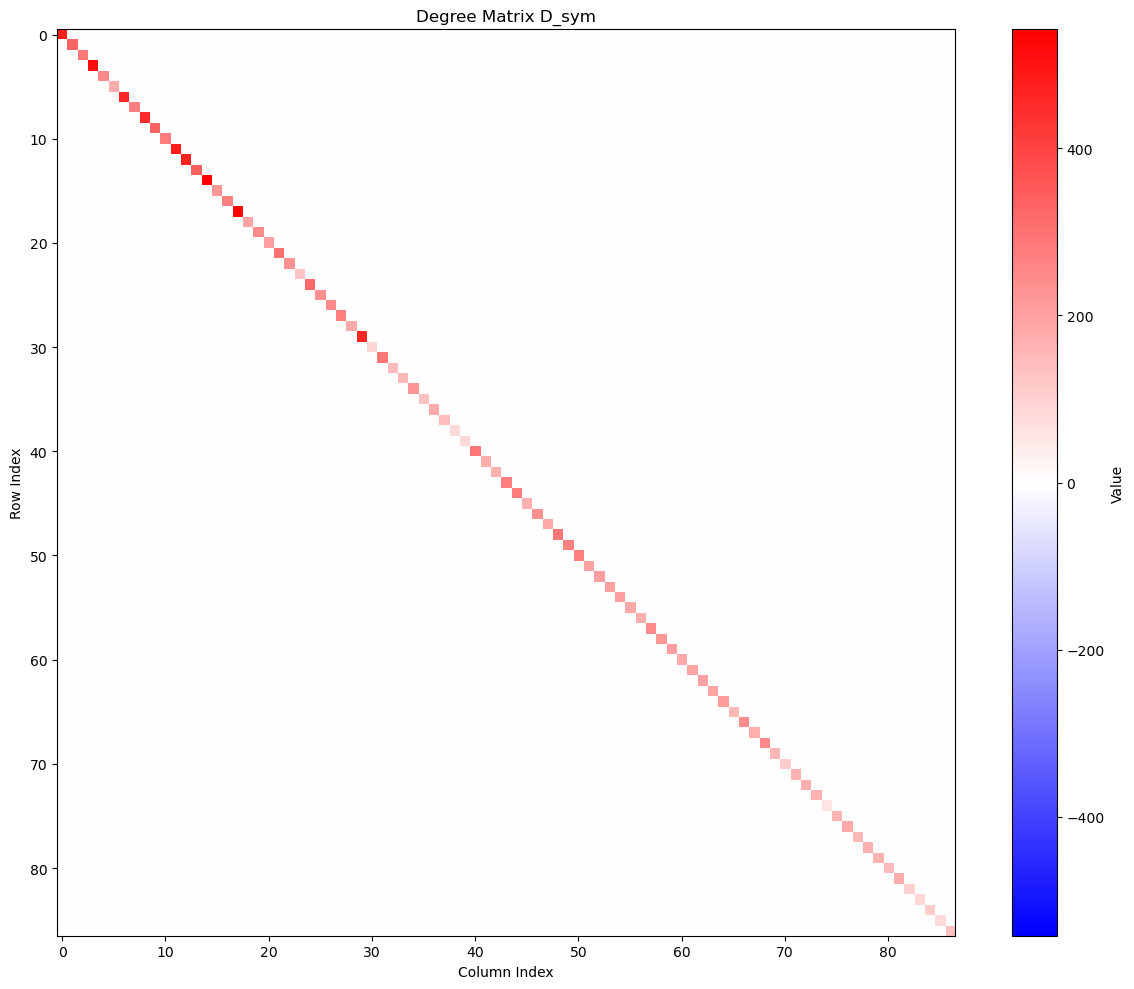

In [157]:
# Visualize the symmetrized degree
# Plot D_sym
plt.figure(figsize=(12, 10))
plt.imshow(D_sym, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(D_sym)), 
           vmax=np.max(np.abs(D_sym)), 
           interpolation='none')
plt.colorbar(label='Value')
plt.title('Degree Matrix D_sym')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

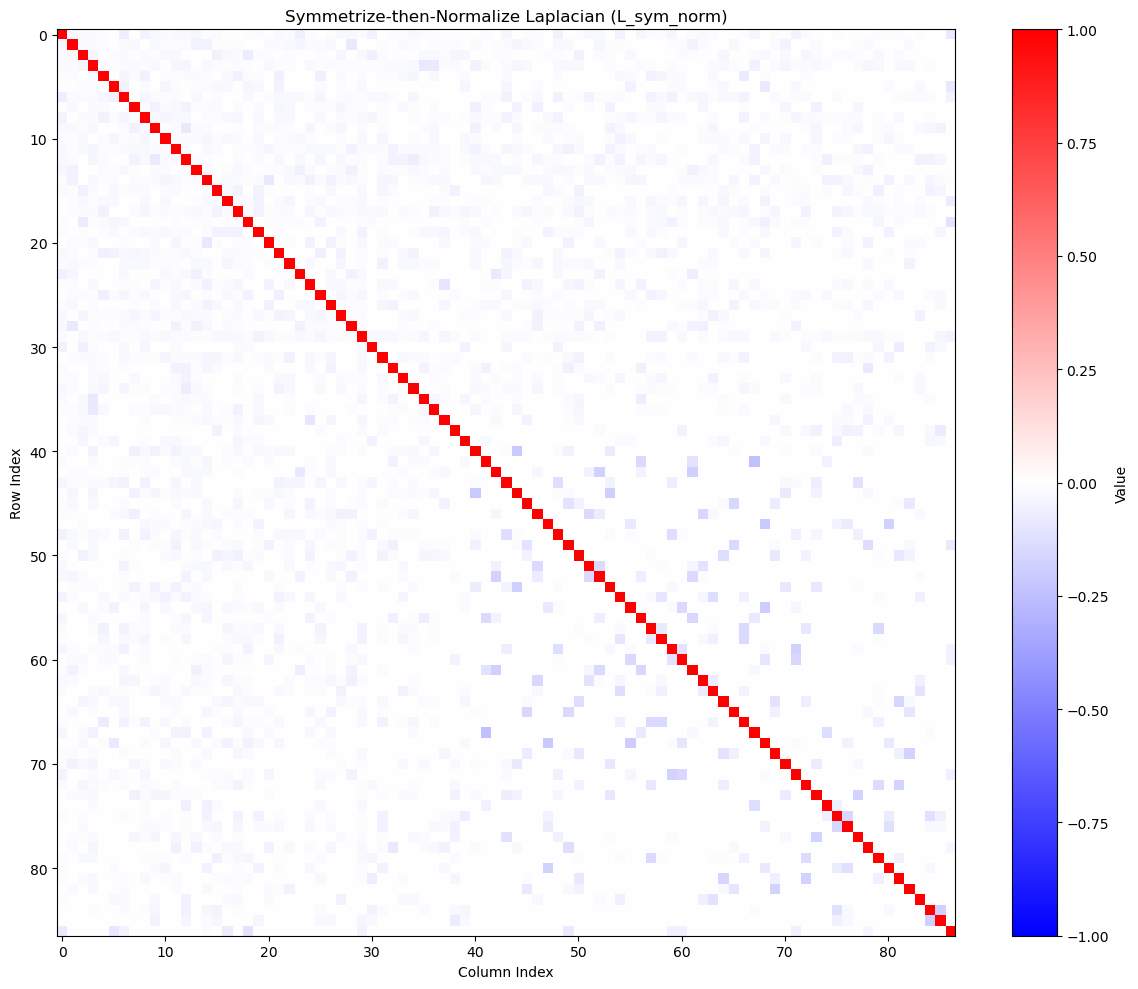

In [158]:
# Visualize the symmetrize-then-normalize Laplacian
plt.figure(figsize=(12, 10))
plt.imshow(L_sym_norm, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(L_sym_norm)), 
           vmax=np.max(np.abs(L_sym_norm)), 
           interpolation='none')
plt.colorbar(label='Value')
plt.title('Symmetrize-then-Normalize Laplacian (L_sym_norm)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

##### Direct symmetrization

Default is row-stochastic (forward).

In [163]:
# Compute L_out_sym: the direct symmetrization of L_out
# L_out_sym = D_out^(-1/2) * (D_out - 1/2(A + A^T)) * D_out^(-1/2)

# First, compute the symmetrized adjacency matrix
A_sym = (A + A.T) / 2

# Compute D_out^(-1/2)
D_out_inv_sqrt = np.linalg.inv(np.sqrt(D_out))

# Compute L_out_sym
L_out_sym = D_out_inv_sqrt @ (D_out - A_sym) @ D_out_inv_sqrt

print(f"L_out_sym shape: {L_out_sym.shape}")

# Verify symmetry of L_out_sym
symmetry_error = np.max(np.abs(L_out_sym - L_out_sym.T))
print(f"L_out_sym symmetry error (should be ~0): {symmetry_error:.2e}")

# Verify properties
row_sums_L_out_sym = np.sum(L_out_sym, axis=1)
print(f"L_out_sym row sums (should be ~0): max abs = {np.abs(row_sums_L_out_sym).max():.2e}")

# Show some statistics
print(f"\nL_out_sym statistics:")
print(f"  Min: {L_out_sym.min():.4f}")
print(f"  Max: {L_out_sym.max():.4f}")
print(f"  Mean: {L_out_sym.mean():.4f}")
print(f"  Std: {L_out_sym.std():.4f}")

L_out_sym shape: (87, 87)
L_out_sym symmetry error (should be ~0): 5.55e-17
L_out_sym row sums (should be ~0): max abs = 2.69e+00

L_out_sym statistics:
  Min: -0.5530
  Max: 1.0000
  Mean: -0.0005
  Std: 0.1113


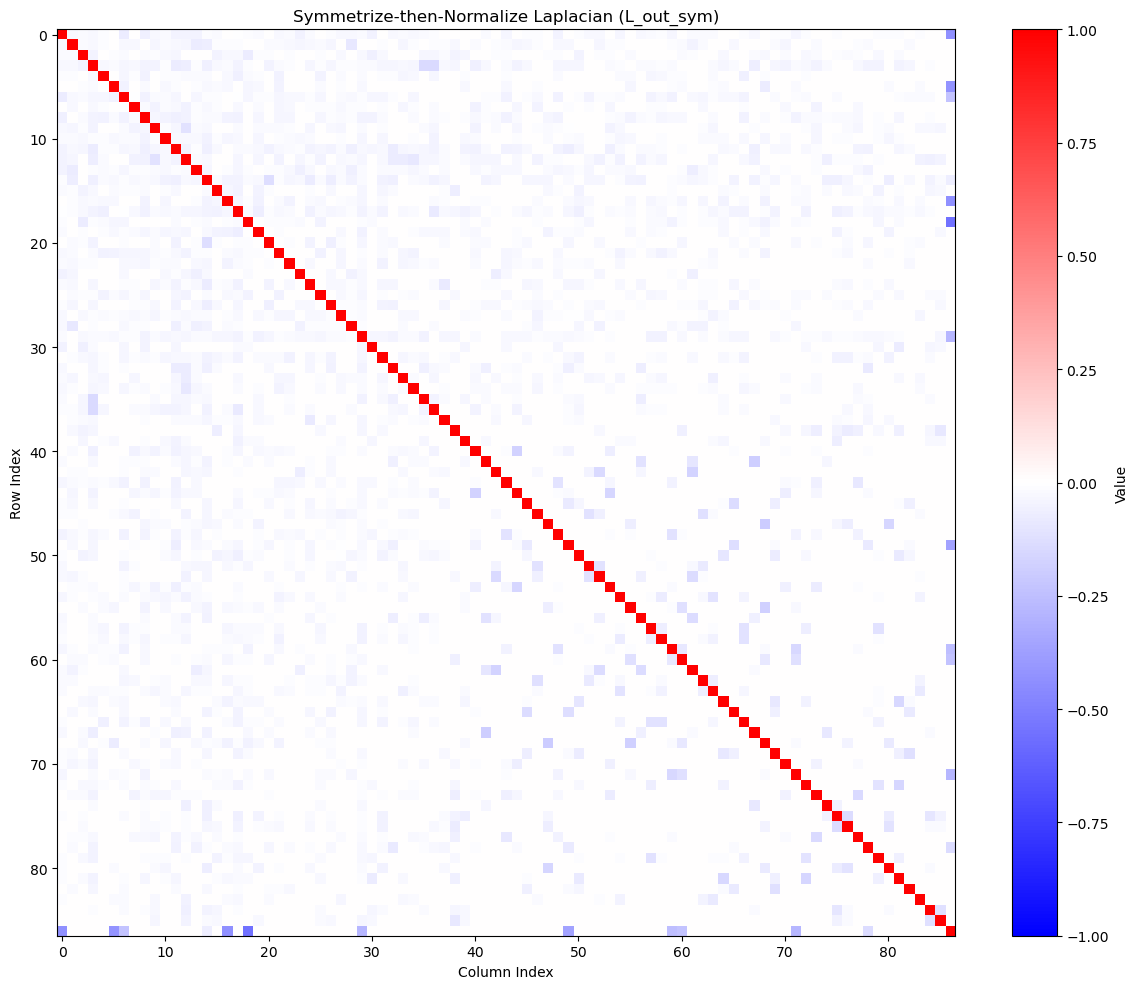

In [164]:
# Visualize L_out_sym
plt.figure(figsize=(12, 10))
plt.imshow(L_out_sym, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(L_out_sym)), 
           vmax=np.max(np.abs(L_out_sym)), 
           interpolation='none')
plt.colorbar(label='Value')
plt.title('Symmetrize-then-Normalize Laplacian (L_out_sym)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

In [ ]:
# Workspace checkpoint
variables_to_keep = ['ctoi_grouped', 'noi_grouped',
                     'C_signed_grouped', 'C_unsigned_grouped',
                     'new_order', 'unique_cell_types', 'cell_type_counts',
                     'A_sym', 'D_sym', 'D_in', 'D_out', 'L_sym_norm', 'L_out_sym', 'L_in', 'L_out', 'L_rw']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 87
	noi_grouped: list, length: 87
	C_signed_grouped: ndarray, shape: (87, 87)
	C_unsigned_grouped: ndarray, shape: (87, 87)
	new_order: list, length: 87
	unique_cell_types: list, length: 2
	cell_type_counts: dict, length: 2
	A_sym: ndarray, shape: (87, 87)
	D_sym: ndarray, shape: (87, 87)
	D_in: ndarray, shape: (87, 87)
	D_out: ndarray, shape: (87, 87)
	L_sym: ndarray, shape: (87, 87)
	L_in: ndarray, shape: (87, 87)
	L_out: ndarray, shape: (87, 87)
	L_rw: ndarray, shape: (87, 87)


### Modularity optimization

#### Louvain method

In [ ]:
A = C_unsigned_grouped

print(f"Matrix A shape: {A.shape}")
print(f"Matrix A type: {type(A)}")
print(f"Matrix A min: {A.min()}, max: {A.max()}")
print(f"Number of non-zero entries: {np.count_nonzero(A)}")

# Convert the unsigned adjacency matrix to a NetworkX graph
G = nx.from_numpy_array(A, create_using=nx.DiGraph())

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Apply Louvain community detection
# Note: networkx uses the python-louvain package for this
try:
    communities = community.louvain_communities(G.to_undirected(), seed=42)
    print(f"Louvain detected {len(communities)} communities")
    
    # Sort communities by size (largest first)
    communities_sorted = sorted(communities, key=len, reverse=True)
    
    # Create community assignment array with sorted community indices
    community_labels = np.zeros(len(A), dtype=int)
    for i, comm in enumerate(communities_sorted):
        for node in comm:
            community_labels[node] = i
    
    # Print community sizes
    community_sizes = [len(comm) for comm in communities_sorted]
    print(f"Community sizes: {community_sizes}")
    
    # Calculate modularity
    modularity = community.modularity(G.to_undirected(), communities_sorted)
    print(f"Modularity: {modularity:.4f}")
    
    # Update communities to use sorted version
    communities = communities_sorted
    
except ImportError:
    print("python-louvain not available, using alternative community detection")
    # Fallback to other community detection methods
    communities = list(community.greedy_modularity_communities(G.to_undirected()))
    print(f"Greedy modularity detected {len(communities)} communities")
    
    # Sort communities by size (largest first)
    communities_sorted = sorted(communities, key=len, reverse=True)
    
    community_labels = np.zeros(len(A), dtype=int)
    for i, comm in enumerate(communities_sorted):
        for node in comm:
            community_labels[node] = i
    
    community_sizes = [len(comm) for comm in communities_sorted]
    print(f"Community sizes: {community_sizes}")
    
    modularity = community.modularity(G.to_undirected(), communities_sorted)
    print(f"Modularity (Newman's Q): {modularity:.4f}")
    
    # Update communities to use sorted version
    communities = communities_sorted

# Store results for further analysis
louvain_communities = communities
louvain_labels = community_labels
louvain_modularity = modularity

Matrix A shape: (87, 87)
Matrix A type: <class 'numpy.ndarray'>
Matrix A min: 0.0, max: 63.0
Number of non-zero entries: 1729
Graph created with 87 nodes and 1729 edges
Louvain detected 4 communities
Community sizes: [24, 24, 20, 19]
Modularity: 0.2123


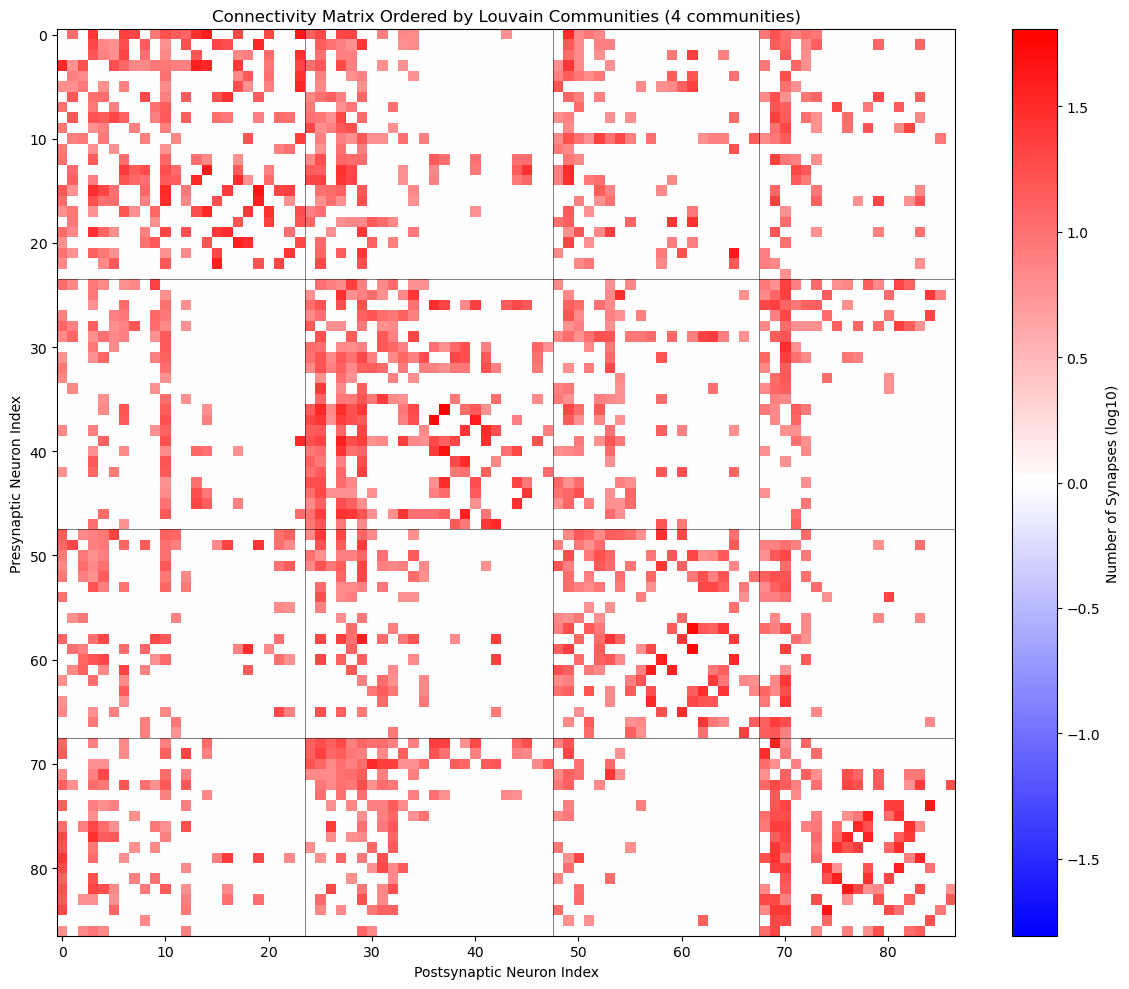


Comparison with original cell type grouping:
Original cell types: 2
Louvain communities: 4
Modularity: 0.2123


In [ ]:
# Visualize the connectivity matrix reordered by Louvain communities
# Create new ordering based on Louvain communities
louvain_order = []
for i, comm in enumerate(louvain_communities):
    louvain_order.extend(sorted(comm))

# Reorder the matrix by Louvain communities
A_louvain_ordered = A[np.ix_(louvain_order, louvain_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(A_louvain_ordered + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(A_louvain_ordered + 1)),
           vmax=np.max(np.log10(A_louvain_ordered + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Connectivity Matrix Ordered by Louvain Communities ({len(louvain_communities)} communities)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add community boundaries
community_boundaries = []
current_pos = 0
for i, comm in enumerate(louvain_communities):
    community_size = len(comm)
    community_boundaries.append(current_pos + community_size)
    current_pos += community_size

# Add lines to separate communities
for boundary in community_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Compare Louvain communities with original cell type grouping
print("\nComparison with original cell type grouping:")
print(f"Original cell types: {len(unique_cell_types)}")
print(f"Louvain communities: {len(louvain_communities)}")
print(f"Modularity (Newman's Q): {louvain_modularity:.4f}")

# Create a mapping to see how cell types are distributed across Louvain communities
cell_type_to_louvain = {}
for i, cell_type in enumerate(ctoi_grouped):
    louvain_comm = louvain_labels[i]
    if cell_type not in cell_type_to_louvain:
        cell_type_to_louvain[cell_type] = {}
    if louvain_comm not in cell_type_to_louvain[cell_type]:
        cell_type_to_louvain[cell_type][louvain_comm] = 0
    cell_type_to_louvain[cell_type][louvain_comm] += 1

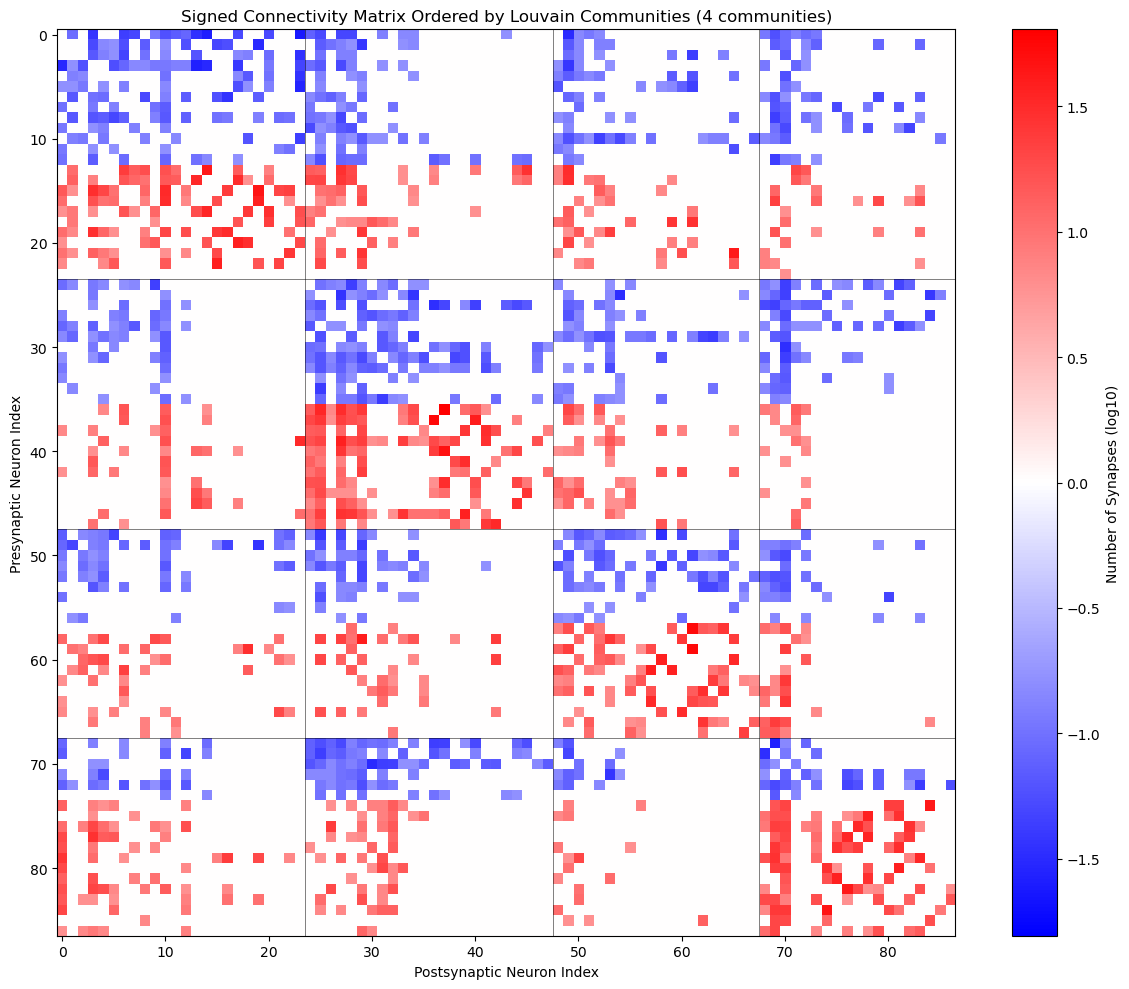


Comparison with original cell type grouping:
Original cell types: 2
Louvain communities: 4
Modularity: 0.2123


In [ ]:
# Visualize the connectivity matrix reordered by Louvain communities
# Create new ordering based on Louvain communities
louvain_order = []
for i, comm in enumerate(louvain_communities):
    louvain_order.extend(sorted(comm))

# Reorder the matrix by Louvain communities
A_signed = C_signed_grouped
A_louvain_ordered = A_signed[np.ix_(louvain_order, louvain_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(A_louvain_ordered) + 1) * np.sign(A_louvain_ordered), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(A_louvain_ordered) + 1)),
           vmax=np.max(np.log10(np.abs(A_louvain_ordered) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Signed Connectivity Matrix Ordered by Louvain Communities ({len(louvain_communities)} communities)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add community boundaries
community_boundaries = []
current_pos = 0
for i, comm in enumerate(louvain_communities):
    community_size = len(comm)
    community_boundaries.append(current_pos + community_size)
    current_pos += community_size

# Add lines to separate communities
for boundary in community_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Compare Louvain communities with original cell type grouping
print("\nComparison with original cell type grouping:")
print(f"Original cell types: {len(unique_cell_types)}")
print(f"Louvain communities: {len(louvain_communities)}")
print(f"Modularity (Newman's Q): {louvain_modularity:.4f}")

# Create a mapping to see how cell types are distributed across Louvain communities
cell_type_to_louvain = {}
for i, cell_type in enumerate(ctoi_grouped):
    louvain_comm = louvain_labels[i]
    if cell_type not in cell_type_to_louvain:
        cell_type_to_louvain[cell_type] = {}
    if louvain_comm not in cell_type_to_louvain[cell_type]:
        cell_type_to_louvain[cell_type][louvain_comm] = 0
    cell_type_to_louvain[cell_type][louvain_comm] += 1

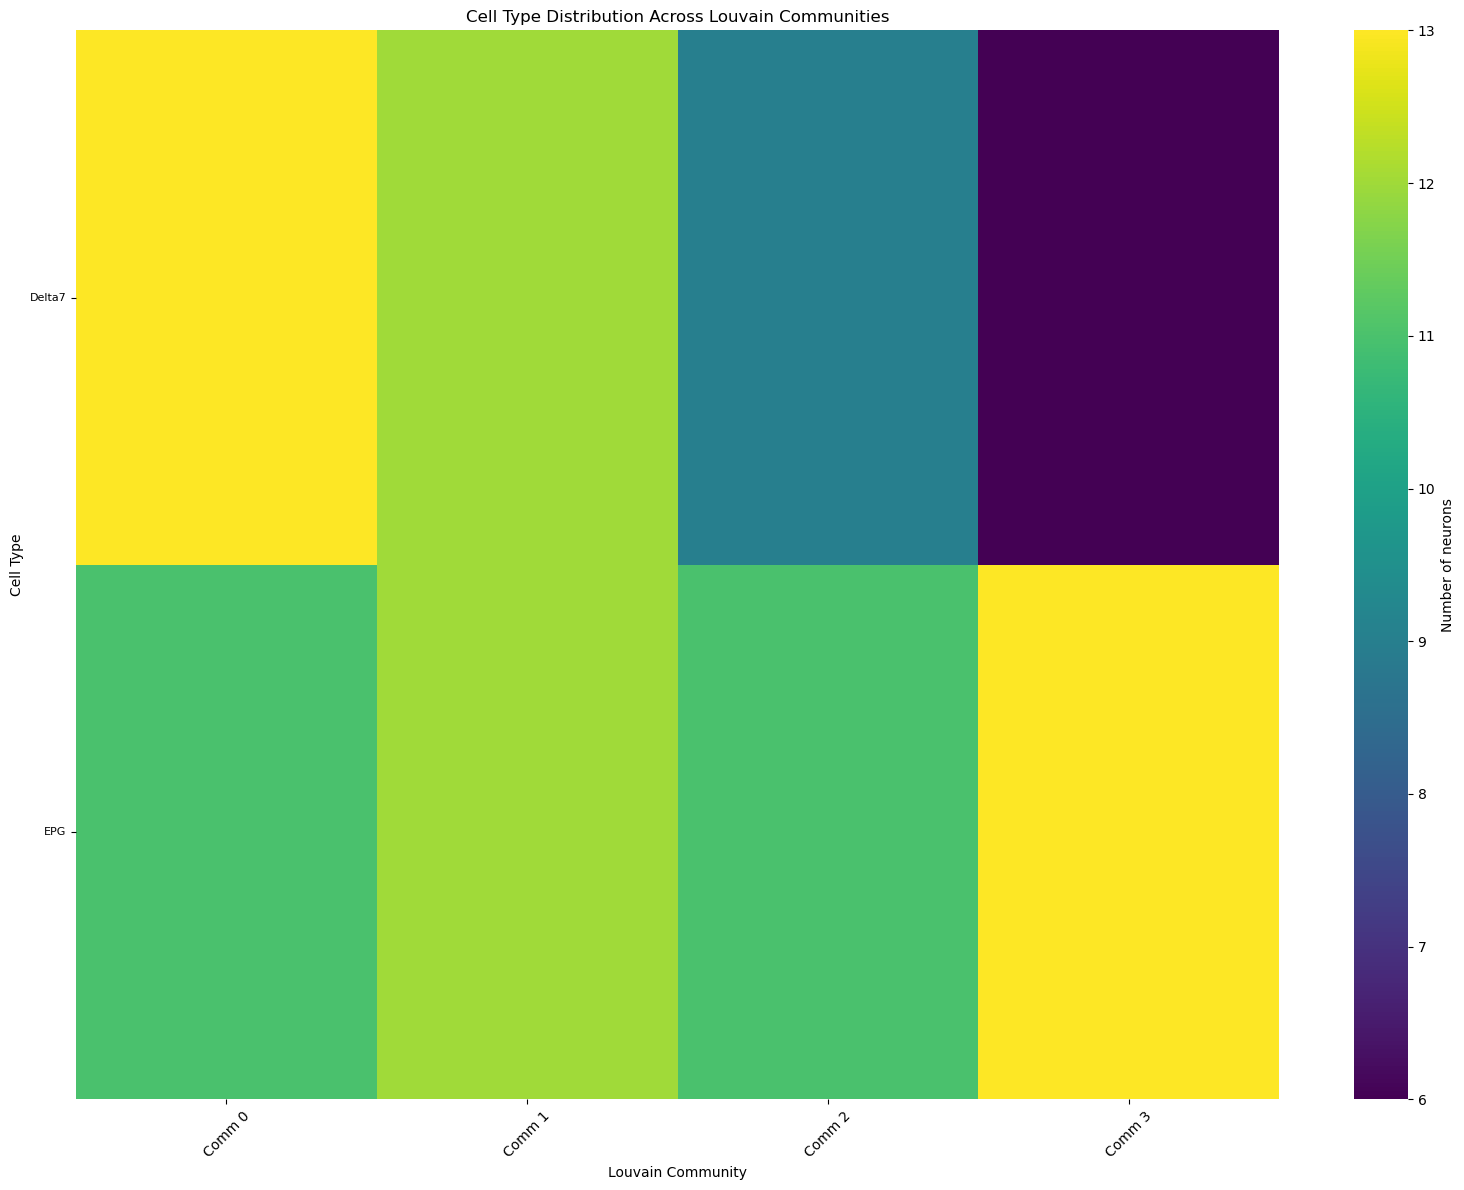

Distribution matrix shape: (2, 4)
Non-zero entries in distribution matrix: 8
Cell types split across multiple communities: 2/2
Average community purity: 0.569
Community purity range: 0.500 - 0.684


In [138]:
# Create a 2D heatmap of cell type distribution across Louvain communities
import seaborn as sns

# Create a matrix: rows = cell types, columns = Louvain communities
n_cell_types = len(unique_cell_types)
n_communities = len(louvain_communities)

# Initialize the distribution matrix
distribution_matrix = np.zeros((n_cell_types, n_communities))

# Fill the matrix
for i, cell_type in enumerate(ctoi_grouped):
    louvain_comm = louvain_labels[i]
    cell_type_idx = unique_cell_types.index(cell_type)
    distribution_matrix[cell_type_idx, louvain_comm] += 1

# Create the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(distribution_matrix, 
            xticklabels=[f'Comm {i}' for i in range(n_communities)],
            yticklabels=unique_cell_types,
            cmap='viridis',
            annot=False,
            fmt='g',
            cbar_kws={'label': 'Number of neurons'})

plt.title('Cell Type Distribution Across Louvain Communities')
plt.xlabel('Louvain Community')
plt.ylabel('Cell Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Show statistics about the distribution
print(f"Distribution matrix shape: {distribution_matrix.shape}")
print(f"Non-zero entries in distribution matrix: {np.count_nonzero(distribution_matrix)}")

# Calculate how many cell types are split across multiple communities
split_cell_types = 0
for i in range(n_cell_types):
    if np.count_nonzero(distribution_matrix[i, :]) > 1:
        split_cell_types += 1

print(f"Cell types split across multiple communities: {split_cell_types}/{n_cell_types}")

# Calculate community purity (max cell type fraction in each community)
community_purity = []
for j in range(n_communities):
    if distribution_matrix[:, j].sum() > 0:
        purity = distribution_matrix[:, j].max() / distribution_matrix[:, j].sum()
        community_purity.append(purity)

print(f"Average community purity: {np.mean(community_purity):.3f}")
print(f"Community purity range: {np.min(community_purity):.3f} - {np.max(community_purity):.3f}")

#### Leiden algorithm

In [ ]:
# Implement Leiden algorithm for community detection
# Convert NetworkX graph to igraph for Leiden algorithm
# Create adjacency list
edges = list(G.edges(data=True))
edge_list = [(u, v) for u, v, d in edges]
weights = [d['weight'] for u, v, d in edges]

# Create igraph
g_ig = ig.Graph(directed=False)
g_ig.add_vertices(G.number_of_nodes())
g_ig.add_edges(edge_list)
g_ig.es['weight'] = weights

# Apply Leiden algorithm
partition = leidenalg.find_partition(g_ig, leidenalg.ModularityVertexPartition, 
                                    weights='weight', seed=42)

# Extract community assignments
leiden_communities = [list(community) for community in partition]
leiden_labels = np.zeros(len(A), dtype=int)

for i, comm in enumerate(leiden_communities):
    for node in comm:
        leiden_labels[node] = i

leiden_modularity = partition.modularity

print(f"Leiden detected {len(leiden_communities)} communities")
leiden_community_sizes = [len(comm) for comm in leiden_communities]
print(f"Community sizes: {sorted(leiden_community_sizes, reverse=True)}")
print(f"Modularity (Newman's Q): {leiden_modularity:.4f}")

Leiden detected 6 communities
Community sizes: [23, 20, 13, 13, 10, 8]
Modularity: 0.1853


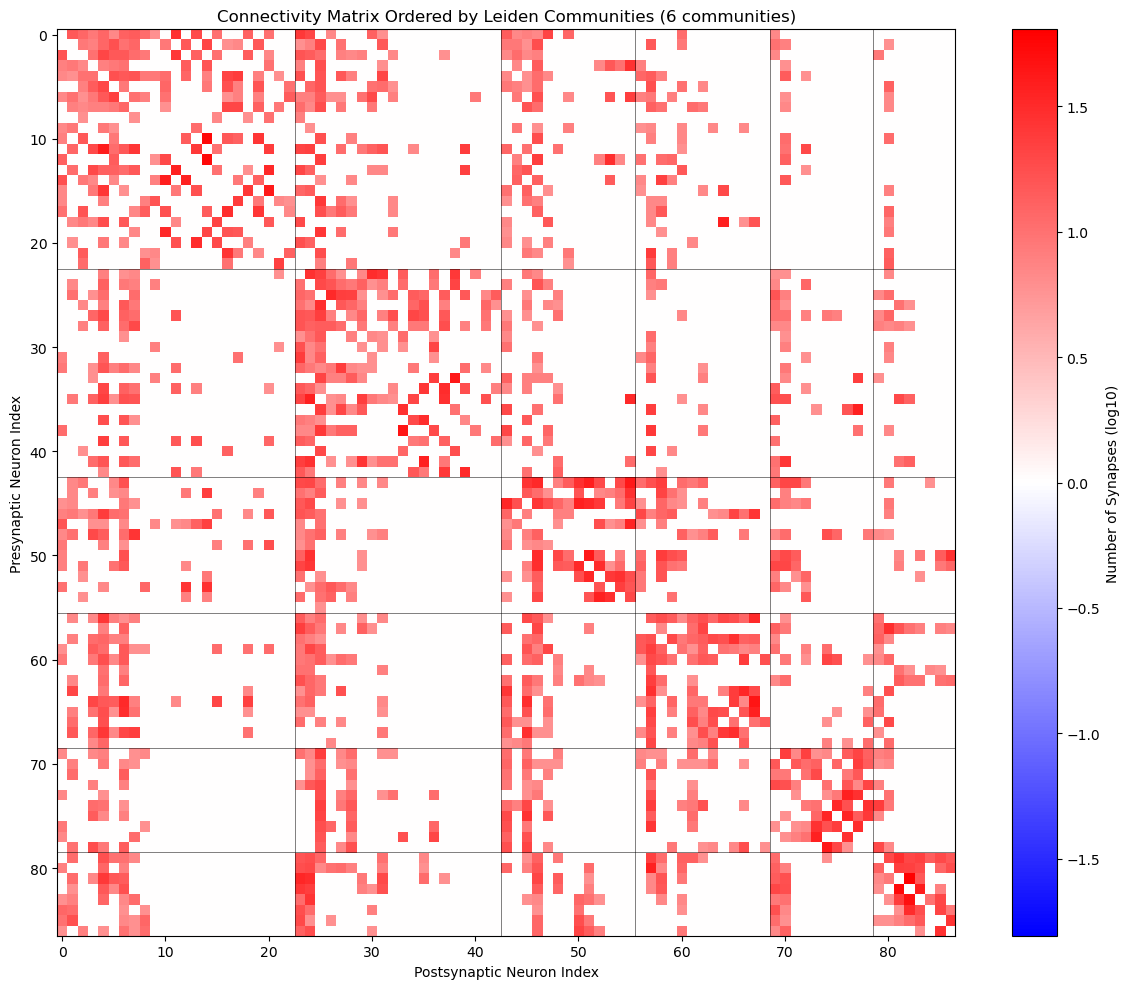


Comparison with original cell type grouping:
Original cell types: 2
Leiden communities: 6
Modularity: 0.1853


In [ ]:
# Visualize Leiden communities (if available)
# Visualize the connectivity matrix reordered by Leiden communities
leiden_order = []
for i, comm in enumerate(leiden_communities):
    leiden_order.extend(sorted(comm))

# Reorder the matrix by Leiden communities
A_leiden_ordered = A[np.ix_(leiden_order, leiden_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(A_leiden_ordered + 1), 
            cmap='bwr', aspect='auto',
            vmin=-np.max(np.log10(A_leiden_ordered + 1)),
            vmax=np.max(np.log10(A_leiden_ordered + 1)),
            interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Connectivity Matrix Ordered by Leiden Communities ({len(leiden_communities)} communities)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add community boundaries
leiden_boundaries = []
current_pos = 0
for i, comm in enumerate(leiden_communities):
    community_size = len(comm)
    leiden_boundaries.append(current_pos + community_size)
    current_pos += community_size

# Add lines to separate communities
for boundary in leiden_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Compare Leiden communities with original cell type grouping
print("\nComparison with original cell type grouping:")
print(f"Original cell types: {len(unique_cell_types)}")
print(f"Leiden communities: {len(leiden_communities)}")
print(f"Modularity (Newman's Q): {leiden_modularity:.4f}")

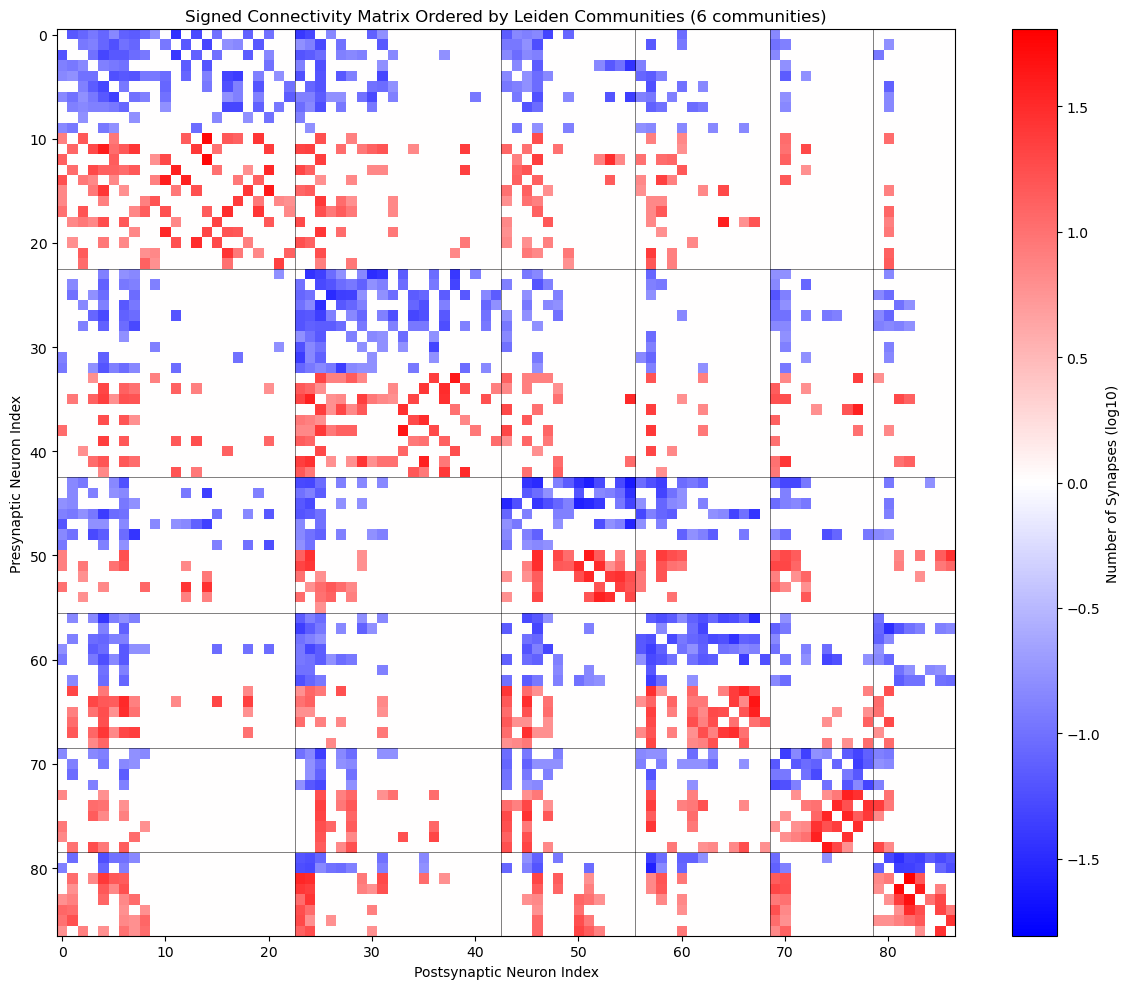


Comparison with original cell type grouping:
Original cell types: 2
Leiden communities: 6
Modularity: 0.1853


In [ ]:
# Visualize Leiden communities (if available)
# Visualize the connectivity matrix reordered by Leiden communities
leiden_order = []
for i, comm in enumerate(leiden_communities):
    leiden_order.extend(sorted(comm))

# Reorder the matrix by Leiden communities
A_signed = C_signed_grouped
A_leiden_ordered = A_signed[np.ix_(leiden_order, leiden_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(A_leiden_ordered) + 1) * np.sign(A_leiden_ordered), 
                   cmap='bwr', aspect='auto',
                   vmin=-np.max(np.log10(np.abs(A_leiden_ordered) + 1)),
                   vmax=np.max(np.log10(np.abs(A_leiden_ordered) + 1)),
                   interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Signed Connectivity Matrix Ordered by Leiden Communities ({len(leiden_communities)} communities)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add community boundaries
leiden_boundaries = []
current_pos = 0
for i, comm in enumerate(leiden_communities):
    community_size = len(comm)
    leiden_boundaries.append(current_pos + community_size)
    current_pos += community_size

# Add lines to separate communities
for boundary in leiden_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Compare Leiden communities with original cell type grouping
print("\nComparison with original cell type grouping:")
print(f"Original cell types: {len(unique_cell_types)}")
print(f"Leiden communities: {len(leiden_communities)}")
print(f"Modularity (Newman's Q): {leiden_modularity:.4f}")

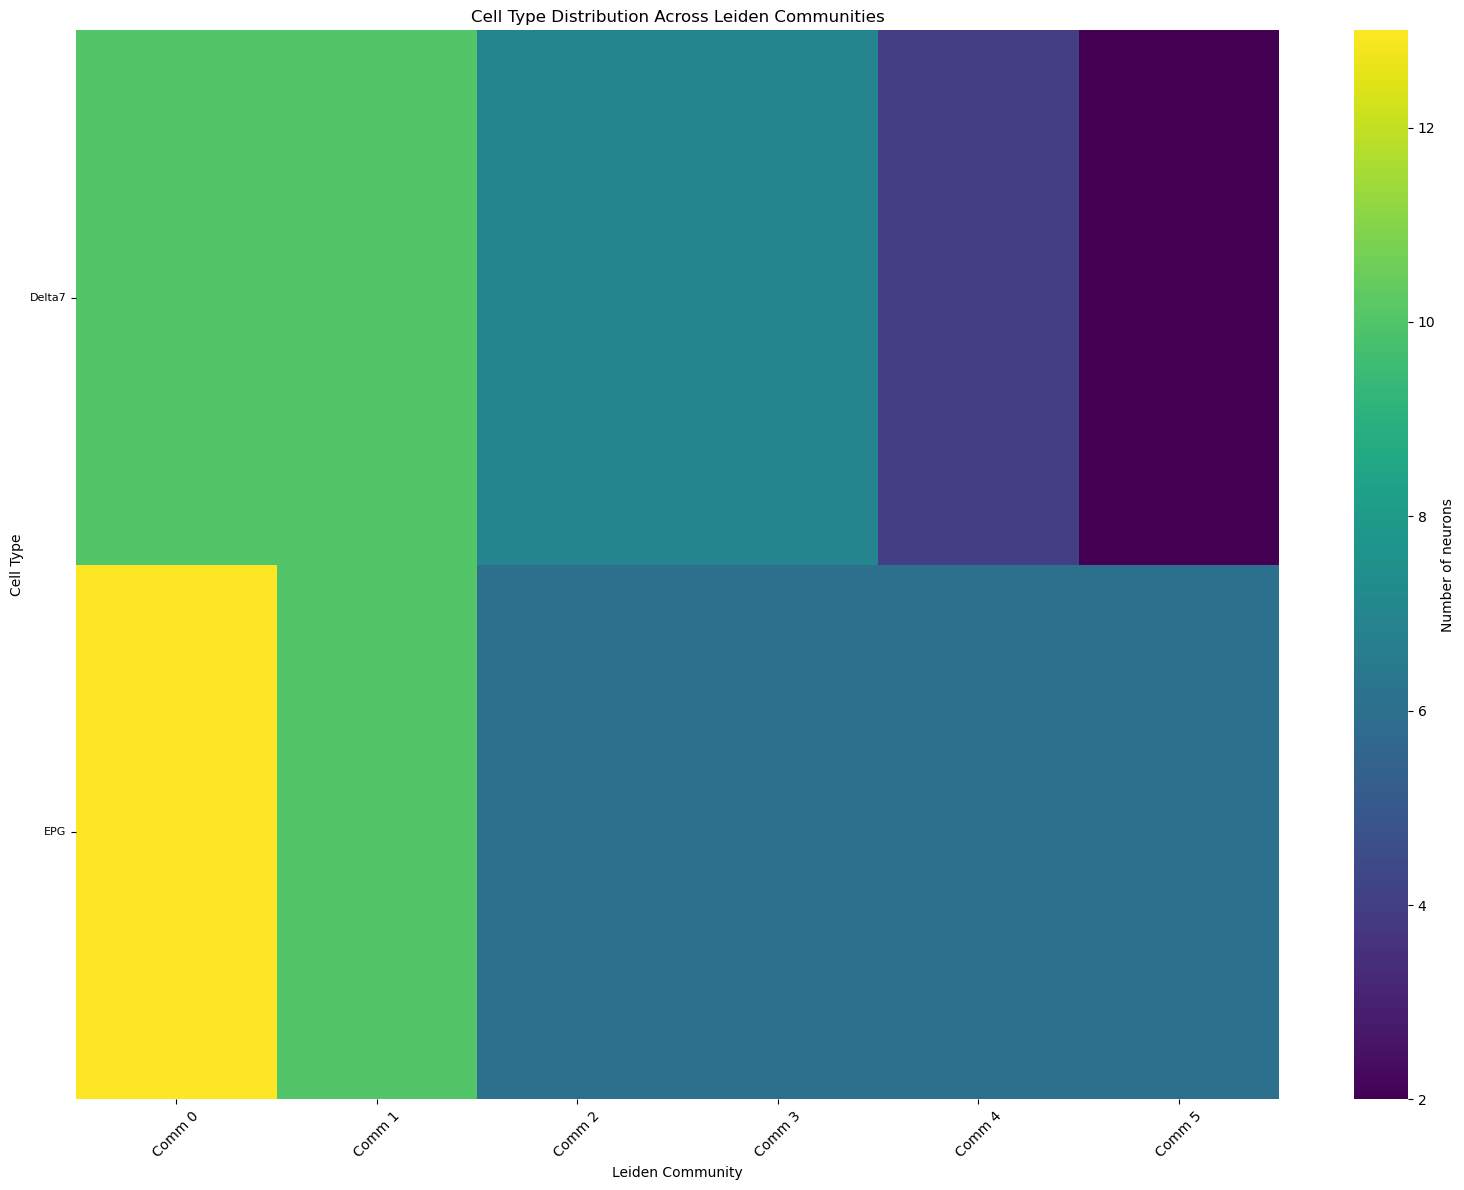

Leiden distribution matrix shape: (2, 6)
Non-zero entries in distribution matrix: 12
Cell types split across multiple communities: 2/2
Average community purity: 0.582
Community purity range: 0.500 - 0.750


In [141]:
# Create 2D heatmap for Leiden method (if available)
# Create a matrix: rows = cell types, columns = Leiden communities
n_leiden_communities = len(leiden_communities)

# Initialize the distribution matrix
leiden_distribution_matrix = np.zeros((n_cell_types, n_leiden_communities))

# Fill the matrix
for i, cell_type in enumerate(ctoi_grouped):
    leiden_comm = leiden_labels[i]
    cell_type_idx = unique_cell_types.index(cell_type)
    leiden_distribution_matrix[cell_type_idx, leiden_comm] += 1

# Create the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(leiden_distribution_matrix, 
            xticklabels=[f'Comm {i}' for i in range(n_leiden_communities)],
            yticklabels=unique_cell_types,
            cmap='viridis',
            annot=False,
            fmt='g',
            cbar_kws={'label': 'Number of neurons'})

plt.title('Cell Type Distribution Across Leiden Communities')
plt.xlabel('Leiden Community')
plt.ylabel('Cell Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Show statistics about the distribution
print(f"Leiden distribution matrix shape: {leiden_distribution_matrix.shape}")
print(f"Non-zero entries in distribution matrix: {np.count_nonzero(leiden_distribution_matrix)}")

# Calculate how many cell types are split across multiple communities
leiden_split_cell_types = 0
for i in range(n_cell_types):
    if np.count_nonzero(leiden_distribution_matrix[i, :]) > 1:
        leiden_split_cell_types += 1

print(f"Cell types split across multiple communities: {leiden_split_cell_types}/{n_cell_types}")

# Calculate community purity
leiden_community_purity = []
for j in range(n_leiden_communities):
    if leiden_distribution_matrix[:, j].sum() > 0:
        purity = leiden_distribution_matrix[:, j].max() / leiden_distribution_matrix[:, j].sum()
        leiden_community_purity.append(purity)

print(f"Average community purity: {np.mean(leiden_community_purity):.3f}")
print(f"Community purity range: {np.min(leiden_community_purity):.3f} - {np.max(leiden_community_purity):.3f}")

### Degree-corrected SBM

In [227]:
K = 10  # Number of blocks

In [228]:
# Prepare the adjacency matrix A for DC-SBM fitting
# Use the Delta7+EPG subset connectivity matrix (87 x 87)
A_dcsbm = C_unsigned_grouped.copy()

print(f"Input matrix A shape: {A_dcsbm.shape}")
print(f"Matrix type: {type(A_dcsbm)}")
print(f"Number of non-zero entries: {np.count_nonzero(A_dcsbm)}")
print(f"Matrix density: {np.count_nonzero(A_dcsbm) / (A_dcsbm.shape[0] * A_dcsbm.shape[1]):.3f}")

# Verify matrix properties
print(f"\nMatrix statistics:")
print(f"Min value: {A_dcsbm.min()}")
print(f"Max value: {A_dcsbm.max()}")
print(f"Mean value: {A_dcsbm.mean():.3f}")

# Compute degrees
k_out, k_in = degrees(A_dcsbm)
print(f"\nDegree statistics:")
print(f"Out-degree range: [{k_out.min():.0f}, {k_out.max():.0f}]")
print(f"In-degree range: [{k_in.min():.0f}, {k_in.max():.0f}]")
print(f"Mean out-degree: {k_out.mean():.2f}")
print(f"Mean in-degree: {k_in.mean():.2f}")

Input matrix A shape: (87, 87)
Matrix type: <class 'numpy.ndarray'>
Number of non-zero entries: 1729
Matrix density: 0.228

Matrix statistics:
Min value: 0.0
Max value: 63.0
Mean value: 2.634

Degree statistics:
Out-degree range: [5, 471]
In-degree range: [23, 812]
Mean out-degree: 229.11
Mean in-degree: 229.11


In [229]:
# Split data into training and validation sets
print("Splitting data for cross-validation...")
A_train, A_val, mask_val = heldout_split(A_dcsbm, frac=0.1, stratify_degrees=True, seed=42)

print(f"Original matrix: {A_dcsbm.shape}, {np.count_nonzero(A_dcsbm)} non-zeros")
print(f"Training matrix: {A_train.shape}, {np.count_nonzero(A_train.toarray())} non-zeros")
print(f"Validation matrix: {A_val.shape}, {np.count_nonzero(A_val.toarray())} non-zeros")
print(f"Validation mask: {mask_val.shape}, {np.count_nonzero(mask_val.toarray())} entries")

# Verify split
total_train = np.count_nonzero(A_train.toarray())
total_val = np.count_nonzero(A_val.toarray())
total_orig = np.count_nonzero(A_dcsbm)
print(f"\nSplit verification:")
print(f"Train + validation edges: {total_train + total_val} (original: {total_orig})")
print(f"Held-out fraction: {total_val / total_orig:.3f}")

Splitting data for cross-validation...
Original matrix: (87, 87), 1729 non-zeros
Training matrix: (87, 87), 1558 non-zeros
Validation matrix: (87, 87), 171 non-zeros
Validation mask: (87, 87), 171 entries

Split verification:
Train + validation edges: 1729 (original: 1729)
Held-out fraction: 0.099


In [230]:
# Fit DC-SBM
# Initialize model
model = DCSBM(K=K, max_iter=200, tol=1e-4, seed=42, init="spectral")

# Fit the model
model.fit(A_train)

# Print results
print(f"Converged: {model.converged_}")
print(f"Number of iterations: {model.n_iter_}")
print(f"Final ELBO: {model.elbo_[-1]:.4f}")

# Get block assignments
labels = model.predict()
print(f"\nBlock assignments:")
print(f"Block 0: {np.sum(labels == 0)} neurons")
print(f"Block 1: {np.sum(labels == 1)} neurons")

# Analyze block composition by cell type
print(f"\nBlock composition by cell type:")
for block_id in range(2):
    block_mask = labels == block_id
    block_cell_types = [ctoi_grouped[i] for i in range(len(ctoi_grouped)) if block_mask[i]]
    cell_type_counts_block = {ct: block_cell_types.count(ct) for ct in set(block_cell_types)}
    print(f"Block {block_id}: {dict(sorted(cell_type_counts_block.items()))}")

# Get model parameters
params = model.get_params()
print(f"\nModel parameters:")
print(f"Omega (block-block rates):")
print(params['Omega'])
print(f"Block proportions (pi): {params['pi']}")

Converged: True
Number of iterations: 6
Final ELBO: 18491.4586

Block assignments:
Block 0: 8 neurons
Block 1: 9 neurons

Block composition by cell type:
Block 0: {'Delta7': 4, 'EPG': 4}
Block 1: {'Delta7': 3, 'EPG': 6}

Model parameters:
Omega (block-block rates):
[[6.74000000e+02 1.05000000e+02 4.12526594e-11 1.26702743e+02
  4.73000000e+02 6.10000000e+01 5.80000000e+01 1.17000000e+02
  1.47000000e+02 3.69297257e+02]
 [2.04000000e+02 6.74062500e+02 3.21234962e-11 5.79217744e+01
  1.92937500e+02 1.13921875e+02 5.00000000e+00 1.00000000e+01
  1.06000000e+02 1.40078226e+02]
 [8.00000000e+00 3.35016568e-11 1.87000000e+02 4.19217744e+01
  1.56000000e+02 1.06000000e+02 9.00000000e+00 1.30000000e+01
  1.90000000e+01 1.50782256e+01]
 [5.47809683e+01 3.00000000e+01 8.70000000e+01 5.65795325e+02
  2.18749678e+02 2.70812259e+02 2.99061293e+01 3.59429168e-11
  1.68904841e+01 1.03344193e+02]
 [2.64000000e+02 2.15031250e+02 1.25000000e+02 3.33718388e+02
  8.74968750e+02 1.45078125e+02 2.28000000e+

Model Evaluation
Held-out log-likelihood: 9.9924
Training log-likelihood: 11.9999


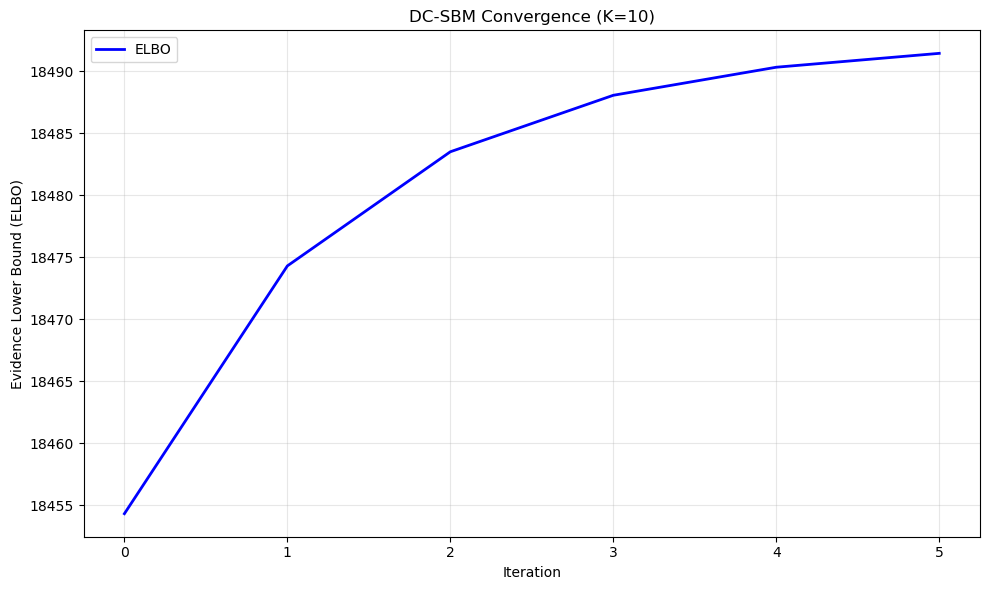


Diagnostics:
ELBO increased monotonically: True
ELBO improvement: 37.1365

Soft membership analysis:
Q matrix shape: (87, 10)
Q row sums (should be ~1): min=1.000000, max=1.000000
Assignment confidence: mean=1.000, min=0.984
Neurons with soft assignments (confidence < 0.8): 0/87


In [231]:
# Evaluate model performance
print("Model Evaluation")
print("=" * 50)

# Compute validation score
val_score = model.score(A_val, mask=mask_val)
print(f"Held-out log-likelihood: {val_score:.4f}")

# Compute training score for comparison
train_score = model.score(A_train)
print(f"Training log-likelihood: {train_score:.4f}")

# Plot ELBO convergence
plt.figure(figsize=(10, 6))
plt.plot(model.elbo_, 'b-', linewidth=2, label='ELBO')
plt.xlabel('Iteration')
plt.ylabel('Evidence Lower Bound (ELBO)')
plt.title(f'DC-SBM Convergence (K={K})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print diagnostic information
diagnostics = model.diagnostics()
print(f"\nDiagnostics:")
print(f"ELBO increased monotonically: {all(diagnostics['elbo_trace'][i+1] >= diagnostics['elbo_trace'][i] - 1e-6 for i in range(len(diagnostics['elbo_trace'])-1))}")
print(f"ELBO improvement: {diagnostics['elbo_trace'][-1] - diagnostics['elbo_trace'][0]:.4f}")

# Analyze soft membership matrix
Q = params['Q']
print(f"\nSoft membership analysis:")
print(f"Q matrix shape: {Q.shape}")
print(f"Q row sums (should be ~1): min={Q.sum(axis=1).min():.6f}, max={Q.sum(axis=1).max():.6f}")

# Show degree of "soft" vs "hard" assignments
assignment_confidence = Q.max(axis=1)
print(f"Assignment confidence: mean={assignment_confidence.mean():.3f}, min={assignment_confidence.min():.3f}")
soft_assignments = np.sum(assignment_confidence < 0.8)
print(f"Neurons with soft assignments (confidence < 0.8): {soft_assignments}/{len(labels)}")

Visualization of DC-SBM Results


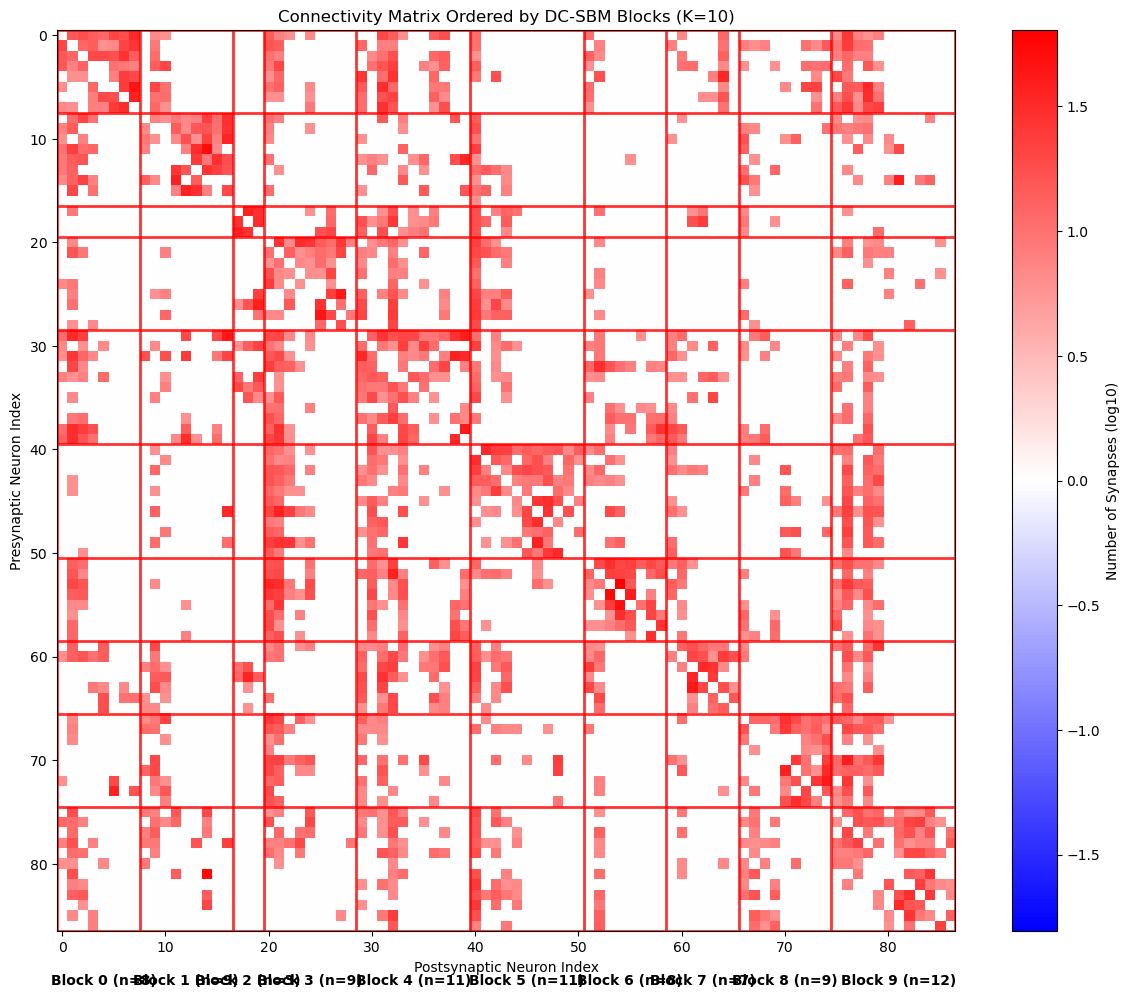


Comparison with biological cell types:
Original cell types: 2 (Delta7, EPG)
DC-SBM blocks: 10


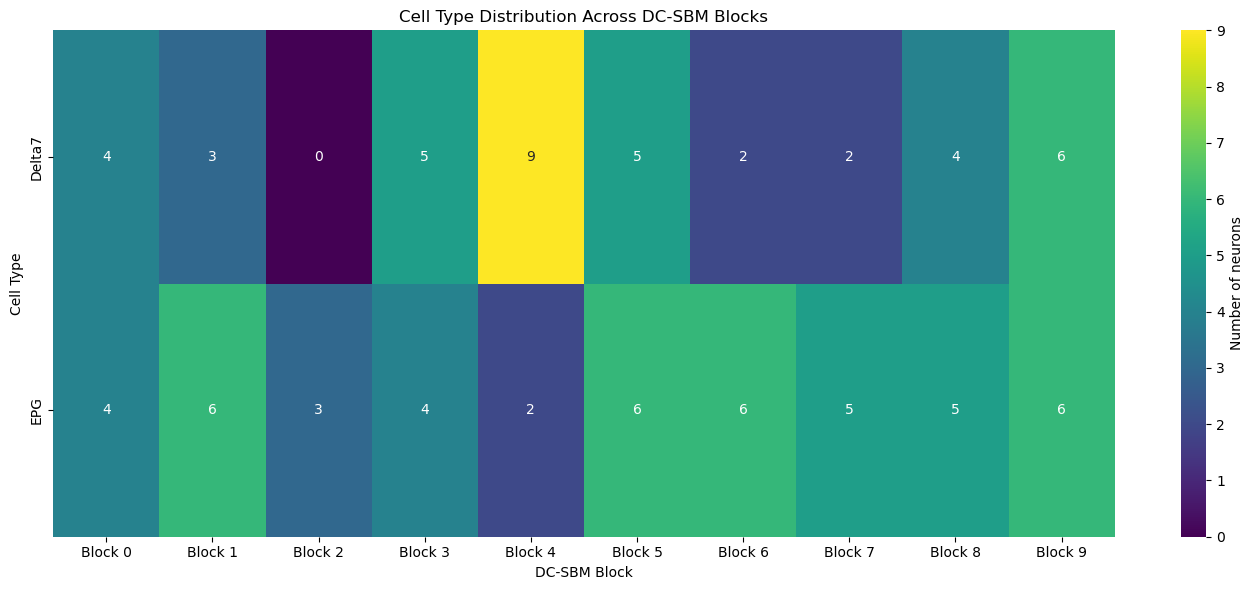


Contingency table (cell types vs DC-SBM blocks):
Cell Type  Block 0  Block 1  Block 2  Block 3  Block 4  Block 5  Block 6  Block 7  Block 8  Block 9  
----------------------------------------------------------------------------------------------------
Delta7            4        3        0        5        9        5        2        2        4        6 
EPG               4        6        3        4        2        6        6        5        5        6 

Block purity analysis:
Block 0: 0.500 purity (dominant: Delta7)
Block 1: 0.667 purity (dominant: EPG)
Block 2: 1.000 purity (dominant: EPG)
Block 3: 0.556 purity (dominant: Delta7)
Block 4: 0.818 purity (dominant: Delta7)
Block 5: 0.545 purity (dominant: EPG)
Block 6: 0.750 purity (dominant: EPG)
Block 7: 0.714 purity (dominant: EPG)
Block 8: 0.556 purity (dominant: EPG)
Block 9: 0.500 purity (dominant: Delta7)


In [234]:
# Visualize DC-SBM results
print("Visualization of DC-SBM Results")
print("=" * 50)

# Create ordering based on DC-SBM block assignments
dcsbm_order = []
for block_id in range(K):
    block_nodes = np.where(labels == block_id)[0]
    dcsbm_order.extend(sorted(block_nodes))

# Reorder the matrix by DC-SBM blocks
A_dcsbm_ordered = A_dcsbm[np.ix_(dcsbm_order, dcsbm_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(A_dcsbm_ordered + 1), 
           cmap='bwr', aspect='auto',
           vmin=-np.max(np.log10(A_dcsbm_ordered + 1)),
           vmax=np.max(np.log10(A_dcsbm_ordered + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Connectivity Matrix Ordered by DC-SBM Blocks (K={K})')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add block boundaries
block_boundaries = np.cumsum([0] + [np.sum(labels == i) for i in range(K)])
for b in block_boundaries:
    plt.axhline(y=b-0.5, color='red', linewidth=2, alpha=0.8)
    plt.axvline(x=b-0.5, color='red', linewidth=2, alpha=0.8)

# Add text annotations for blocks
for block_id in range(K):
    block_size = np.sum(labels == block_id)
    center_pos = (np.sum(labels == block_id) // 2) + (0 if block_id == 0 else block_boundaries[block_id])
    plt.text(center_pos, len(labels)+5, f'Block {block_id} (n={block_size})', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Compare DC-SBM blocks with cell types
print(f"\nComparison with biological cell types:")
print(f"Original cell types: {len(unique_cell_types)} (Delta7, EPG)")
print(f"DC-SBM blocks: {len(np.unique(labels))}")

# Create contingency table
contingency = np.zeros((len(unique_cell_types), K))
for i, cell_type in enumerate(ctoi_grouped):
    block_id = labels[i]
    cell_type_idx = unique_cell_types.index(cell_type)
    contingency[cell_type_idx, block_id] += 1

# Visualize contingency table as a heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(contingency, 
            xticklabels=[f'Block {i}' for i in range(K)],
            yticklabels=unique_cell_types,
            cmap='viridis',
            annot=True,
            fmt='g',
            cbar_kws={'label': 'Number of neurons'})
plt.title('Cell Type Distribution Across DC-SBM Blocks')
plt.xlabel('DC-SBM Block')
plt.ylabel('Cell Type')
plt.tight_layout()
plt.show()

print(f"\nContingency table (cell types vs DC-SBM blocks):")
print(f"{'Cell Type':<10}", end=' ')
for block_id in range(K):
    print(f"{'Block ' + str(block_id):<8}", end=' ')
print()
print("-" * (10 + 9 * K))
for i, cell_type in enumerate(unique_cell_types):
    print(f"{cell_type:<10}", end=' ')
    for block_id in range(K):
        print(f"{contingency[i, block_id]:>8.0f}", end=' ')
    print()

# Calculate block purity with respect to cell types
print(f"\nBlock purity analysis:")
for block_id in range(K):
    block_neurons = np.sum(labels == block_id)
    max_cell_type_in_block = contingency[:, block_id].max()
    purity = max_cell_type_in_block / block_neurons if block_neurons > 0 else 0
    dominant_cell_type = unique_cell_types[np.argmax(contingency[:, block_id])]
    print(f"Block {block_id}: {purity:.3f} purity (dominant: {dominant_cell_type})")

Visualization of DC-SBM Results


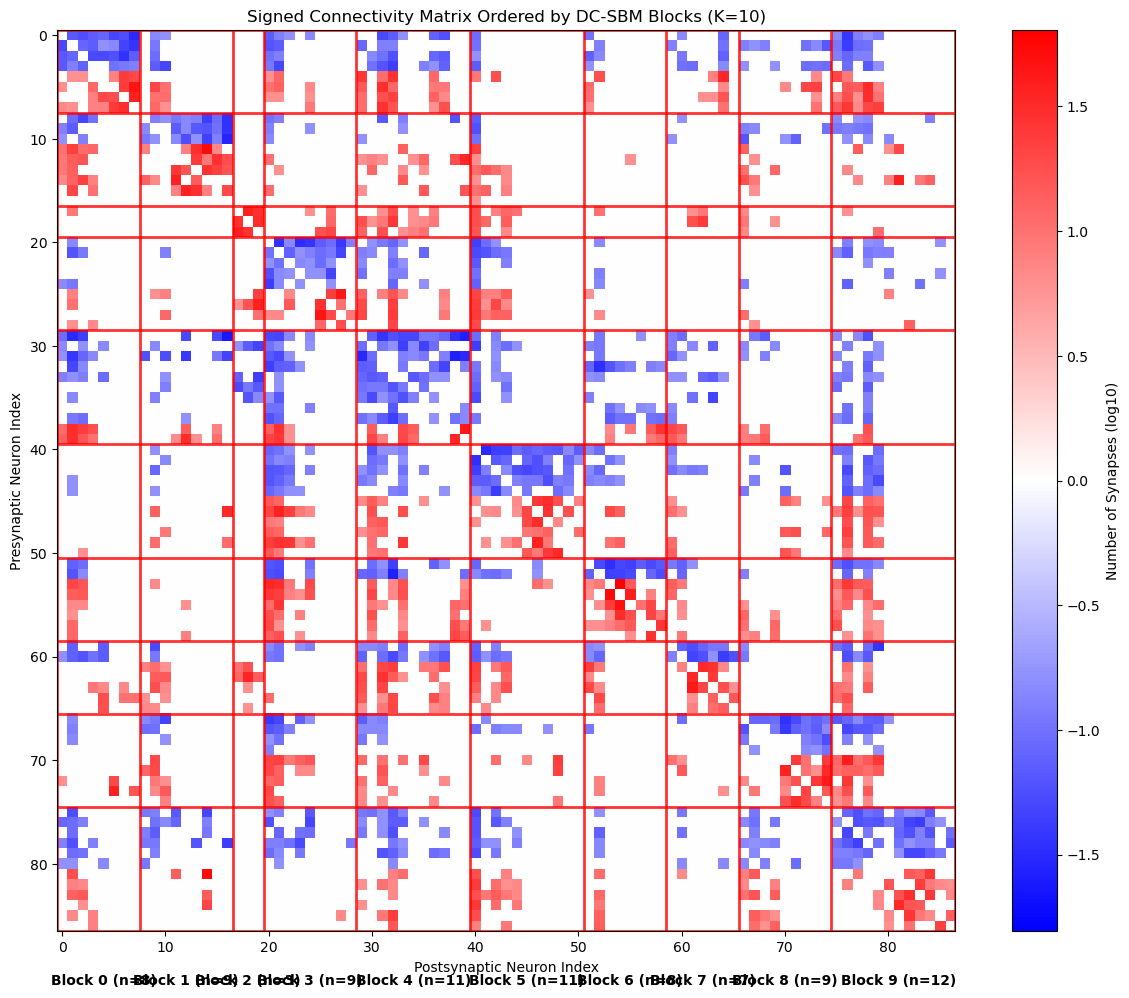

In [233]:
# Visualize DC-SBM results
print("Visualization of DC-SBM Results")
print("=" * 50)

# Create ordering based on DC-SBM block assignments
dcsbm_order = []
for block_id in range(K):
    block_nodes = np.where(labels == block_id)[0]
    dcsbm_order.extend(sorted(block_nodes))

# Reorder the matrix by DC-SBM blocks
A_dcsbm_signed = C_signed_grouped
A_dcsbm_signed_ordered = A_dcsbm_signed[np.ix_(dcsbm_order, dcsbm_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(A_dcsbm_signed_ordered) + 1) * np.sign(A_dcsbm_signed_ordered), 
           cmap='bwr', aspect='auto',
           vmin=-np.max(np.log10(np.abs(A_dcsbm_signed_ordered) + 1)),
           vmax=np.max(np.log10(np.abs(A_dcsbm_signed_ordered) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Signed Connectivity Matrix Ordered by DC-SBM Blocks (K={K})')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add block boundaries
block_boundaries = np.cumsum([0] + [np.sum(labels == i) for i in range(K)])
for b in block_boundaries:
    plt.axhline(y=b-0.5, color='red', linewidth=2, alpha=0.8)
    plt.axvline(x=b-0.5, color='red', linewidth=2, alpha=0.8)

# Add text annotations for blocks
for block_id in range(K):
    block_size = np.sum(labels == block_id)
    center_pos = (np.sum(labels == block_id) // 2) + (0 if block_id == 0 else block_boundaries[block_id])
    plt.text(center_pos, len(labels)+5, f'Block {block_id} (n={block_size})', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Similarity clustering

## System identification

## Role discovery

### Computational library

### Canonical labeling

## System synthesis

## Graph Laplacian